In [50]:
# import json
# from pathlib import Path

# from matplotlib import pyplot as plt
# from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
# import pandas as pd
# import seaborn as sns

# TASK2MaxReturn = {
#     "classic_cartpole": 500,
#     "dmc_walker": 1000
# }

# def plot_violin_plots(task, train_setting, context_idx, modality, save_dir, log_dir, only_decode_ctx, t_step="50k"):
#     train_setting_full = "default" if train_setting == "default" else f"{train_setting}_{context_idx}"

#     experiments = [
#         log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}", 
#         log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}{'_ctx' if not only_decode_ctx else ''}_dec_{modality}_ctx_{t_step}" 
#     ] 
    
#     context_idx = 1 if context_idx == 2 else context_idx
#     context_name = _TASK2CONTEXTS[task][context_idx]["context"]
#     data = {
#         "context_val": [],
#         "input": [],
#         "return": [],
#         "dist": []
#     }
#     ctx_encoding = 'enc_dec' if not only_decode_ctx else 'dec'
#     for exp_path in experiments:
#         experiment = exp_path.name
#         if "ctx" not in experiment:
#             inp = "no_ctx"
#         else:
#             inp = f"{ctx_encoding}_ctx"
#         for seed_path in exp_path.iterdir():
#             eval_file = seed_path / "eval.jsonl"
#             if not eval_file.exists():
#                 continue
#             with eval_file.open() as f:
#                 lines = f.readlines()
#             lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
#             for line in lines:
#                 if context_name in line["ctx"]["changed"] or len(line["ctx"]["changed"]) == 0:
#                     ctx_value = line['ctx']["context"][context_name]
#                     ret = float(line['return'])
#                     dist = line['ctx']["dist"]
#                     data["context_val"].append(ctx_value)
#                     data["input"].append(inp)
#                     data["return"].append(ret)
#                     data["dist"].append(dist)
#     df = pd.DataFrame.from_dict(data)
#     env = _TASK2ENV[task]
#     default_context_val = env.get_default_context()[context_name]
#     if train_setting == "default":
#         interpolate_range = [default_context_val, default_context_val]
#     else:
#         interp_range_pct = _TASK2CONTEXTS[task][context_idx]["train_range"]
#         interpolate_range = [interp_range_pct[0], interp_range_pct[1]]
    
#     plt.figure(figsize=(25,15))
#     sns.violinplot(data=df, x="context_val", y="return", hue="input", split=True, cut=0, native_scale=True, density_norm="width", width=0.5)
#     plt.xlabel(context_name)
#     if interpolate_range[0] == interpolate_range[1]:
#         # draw a vertical line at the context value
#         plt.axvline(interpolate_range[0], color='g', linestyle='--')
#     else:
#         # in the interpolate range, set the background color to green
#         plt.axvspan(interpolate_range[0], interpolate_range[1], facecolor='g', alpha=0.1)
#     # set the y axis to go from 0 to max return
#     plt.ylim(0, TASK2MaxReturn[task] + 10)    
    
#     # Title should be task - modality - context_name
#     title = f"{task} - {context_name} - train: {train_setting} - modality: {modality} - ctx: {ctx_encoding}"
#     plt.title(title)
#     plt.savefig(save_dir / f"{task}_{context_name}_{train_setting}_{modality}_{ctx_encoding}_ctx.png")



# tasks = ["classic_cartpole"]
# train_settings = ["default", "single"] # default context, varying single context in a interpolation range 
# context_ids = [0, 2]
# modalities = ["obs", "img"]
# logdir = Path("../logs")
# save_dir = Path("./plots_old/")

# for task in tasks:
#     for train_setting in train_settings:
#         for context_id in context_ids:
#             for modality in modalities:
#                 for only_decode_ctx in [True, False]:
#                     plot_violin_plots(task, train_setting, context_id, modality, save_dir, logdir, only_decode_ctx)

In [29]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns

TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def plot_violin_plots(task, train_setting, context_idx, modality, save_dir, log_dir, only_decode_ctx, t_step="50k"):
    train_setting_full = "default" if train_setting == "default" else f"{train_setting}_{context_idx}"

    experiments = [
        log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}", 
        log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}{'_ctx' if not only_decode_ctx else ''}_dec_{modality}_ctx_{t_step}" 
    ] 
    modality = "vec" if modality == "obs" else "img"

    context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    data = {
        "context_val": [],
        "input": [],
        "return": [],
    }
    ctx_encoding = 'enc_dec' if not only_decode_ctx else 'dec'
    for exp_path in experiments:
        experiment = exp_path.name
        if "ctx" not in experiment:
            inp = "no_ctx"
        else:
            inp = f"{ctx_encoding}_ctx"
        for seed_path in exp_path.iterdir():
            eval_file = seed_path / "eval.jsonl"
            if not eval_file.exists():
                continue
            with eval_file.open() as f:
                lines = f.readlines()
            lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
            for line in lines:
                if context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0:
                    ctx_value = line['ctx']["context"][context_name]
                    ret = float(line['return'])
                    data["context_val"].append(ctx_value)
                    data["input"].append(inp)
                    data["return"].append(ret)
    df = pd.DataFrame.from_dict(data)
    env = _TASK2ENV[task]
    default_context_val = env.get_default_context()[context_name]
    if train_setting == "default":
        interpolate_range = [default_context_val, default_context_val]
        split = False
        hue = None
        df = df[df["input"] == "no_ctx"]
        save_path = save_dir / f"{task}_{context_name}_{train_setting}_{modality}.pdf"
    else:
        interpolate_range = _TASK2CONTEXTS[task][context_idx]["train_range"]
        split = True
        hue = "input"
        save_path = save_dir / f"{task}_{context_name}_{train_setting}_{modality}_{ctx_encoding}_ctx.pdf"
    
    plt.figure(figsize=(25,15))
    sns.violinplot(data=df, x="context_val", y="return", hue=hue, split=split, cut=0, native_scale=True, density_norm="width", width=0.5)
    plt.xlabel(context_name)
    if interpolate_range[0] == interpolate_range[1]:
        # draw a vertical line at the context value
        plt.axvline(interpolate_range[0], color='g', linestyle='--')
    else:
        # in the interpolate range, set the background color to green
        plt.axvspan(interpolate_range[0], interpolate_range[1], facecolor='g', alpha=0.1)
    # set the y axis to go from 0 to max return
    plt.ylim(0, TASK2MaxReturn[task] + 10)    
    
    # Title should be task - modality - context_name
    title = f"{task} - ctx: {context_name} - train: {train_setting} - modality: {modality}"
    plt.title(title)
    plt.savefig(save_path)




/tmp/ipykernel_2899061/3321071161.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(25,15))


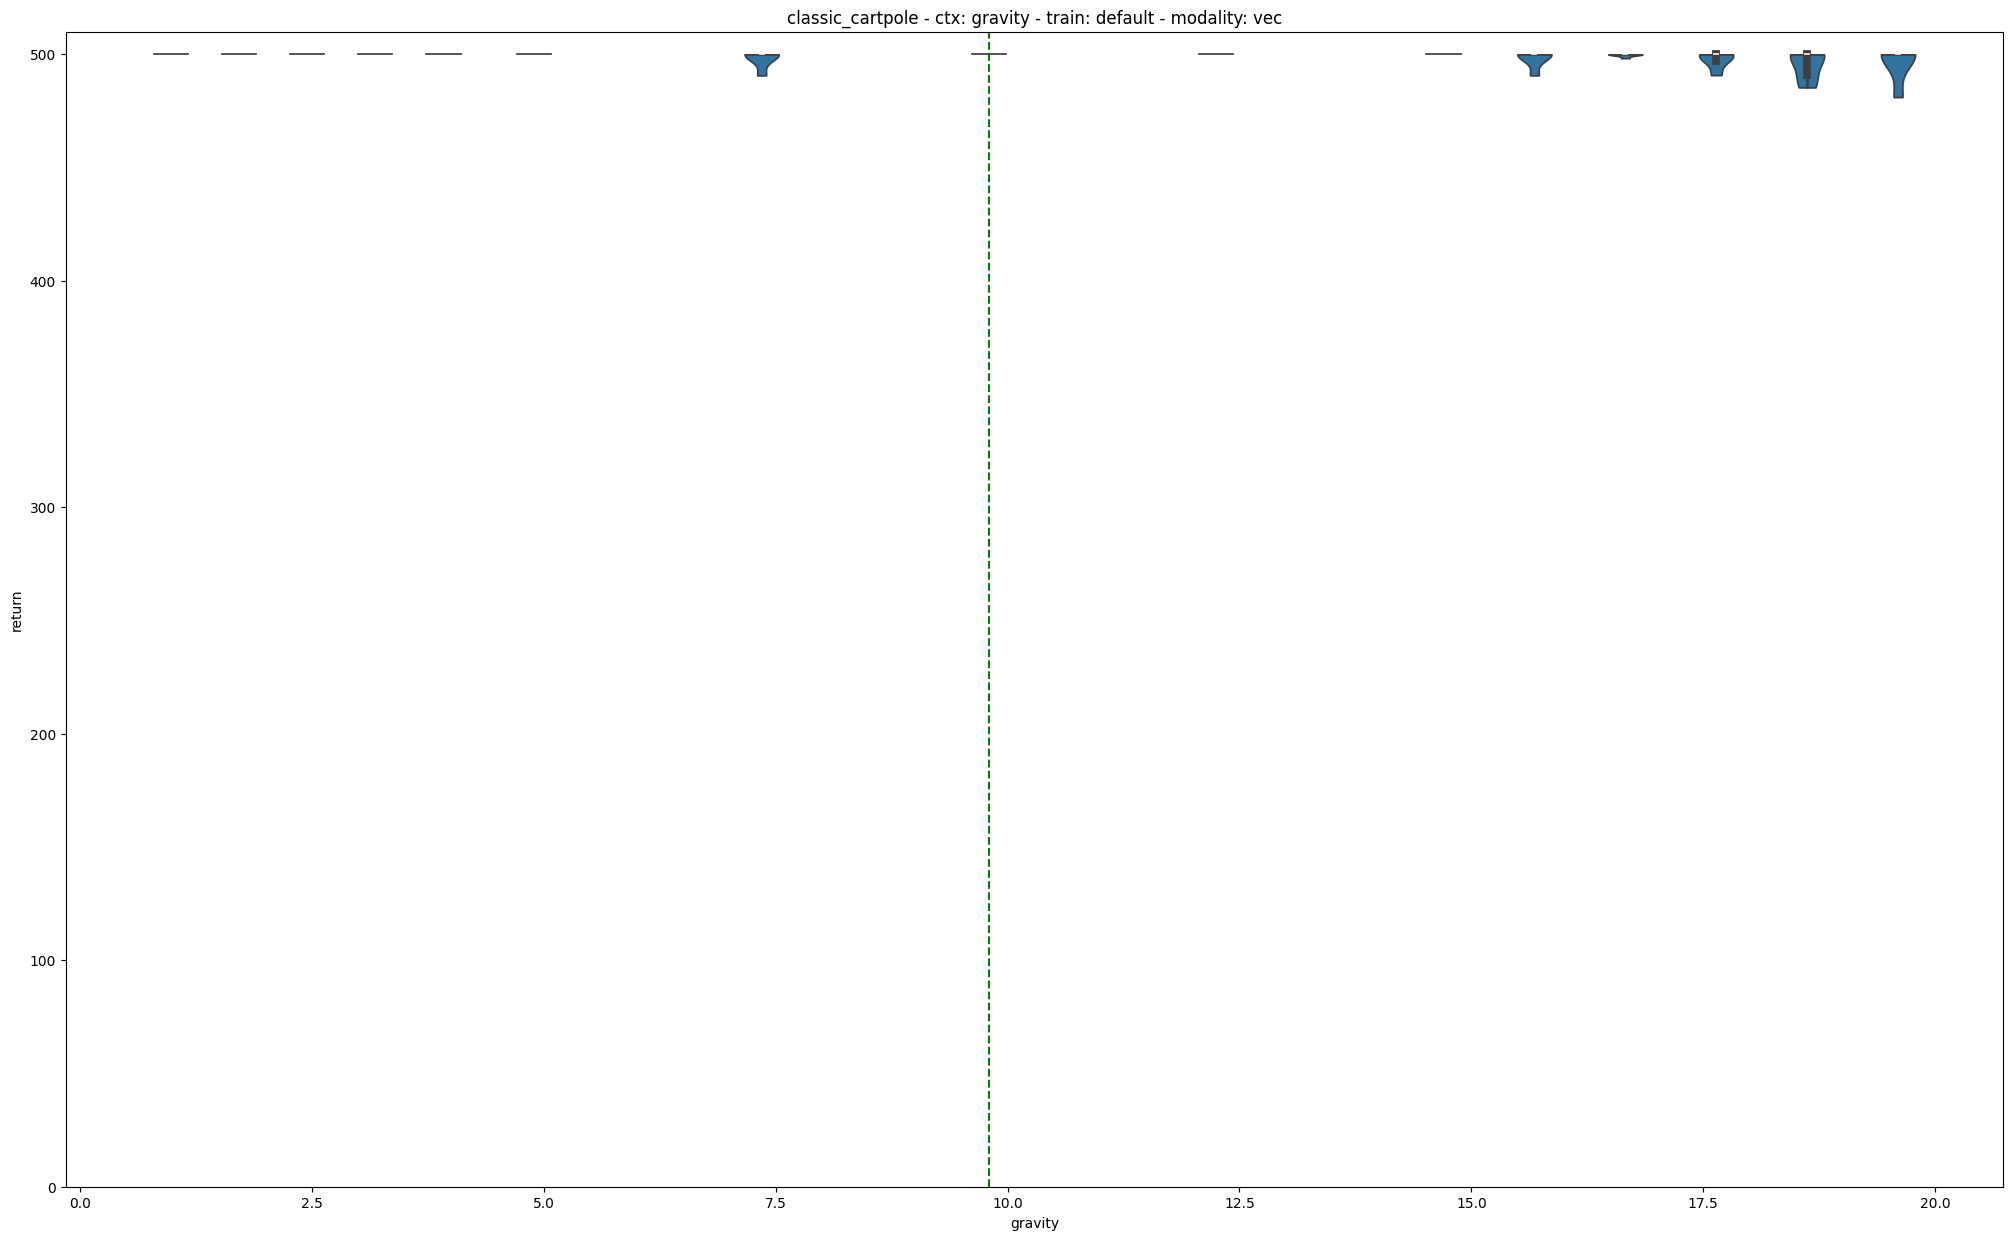

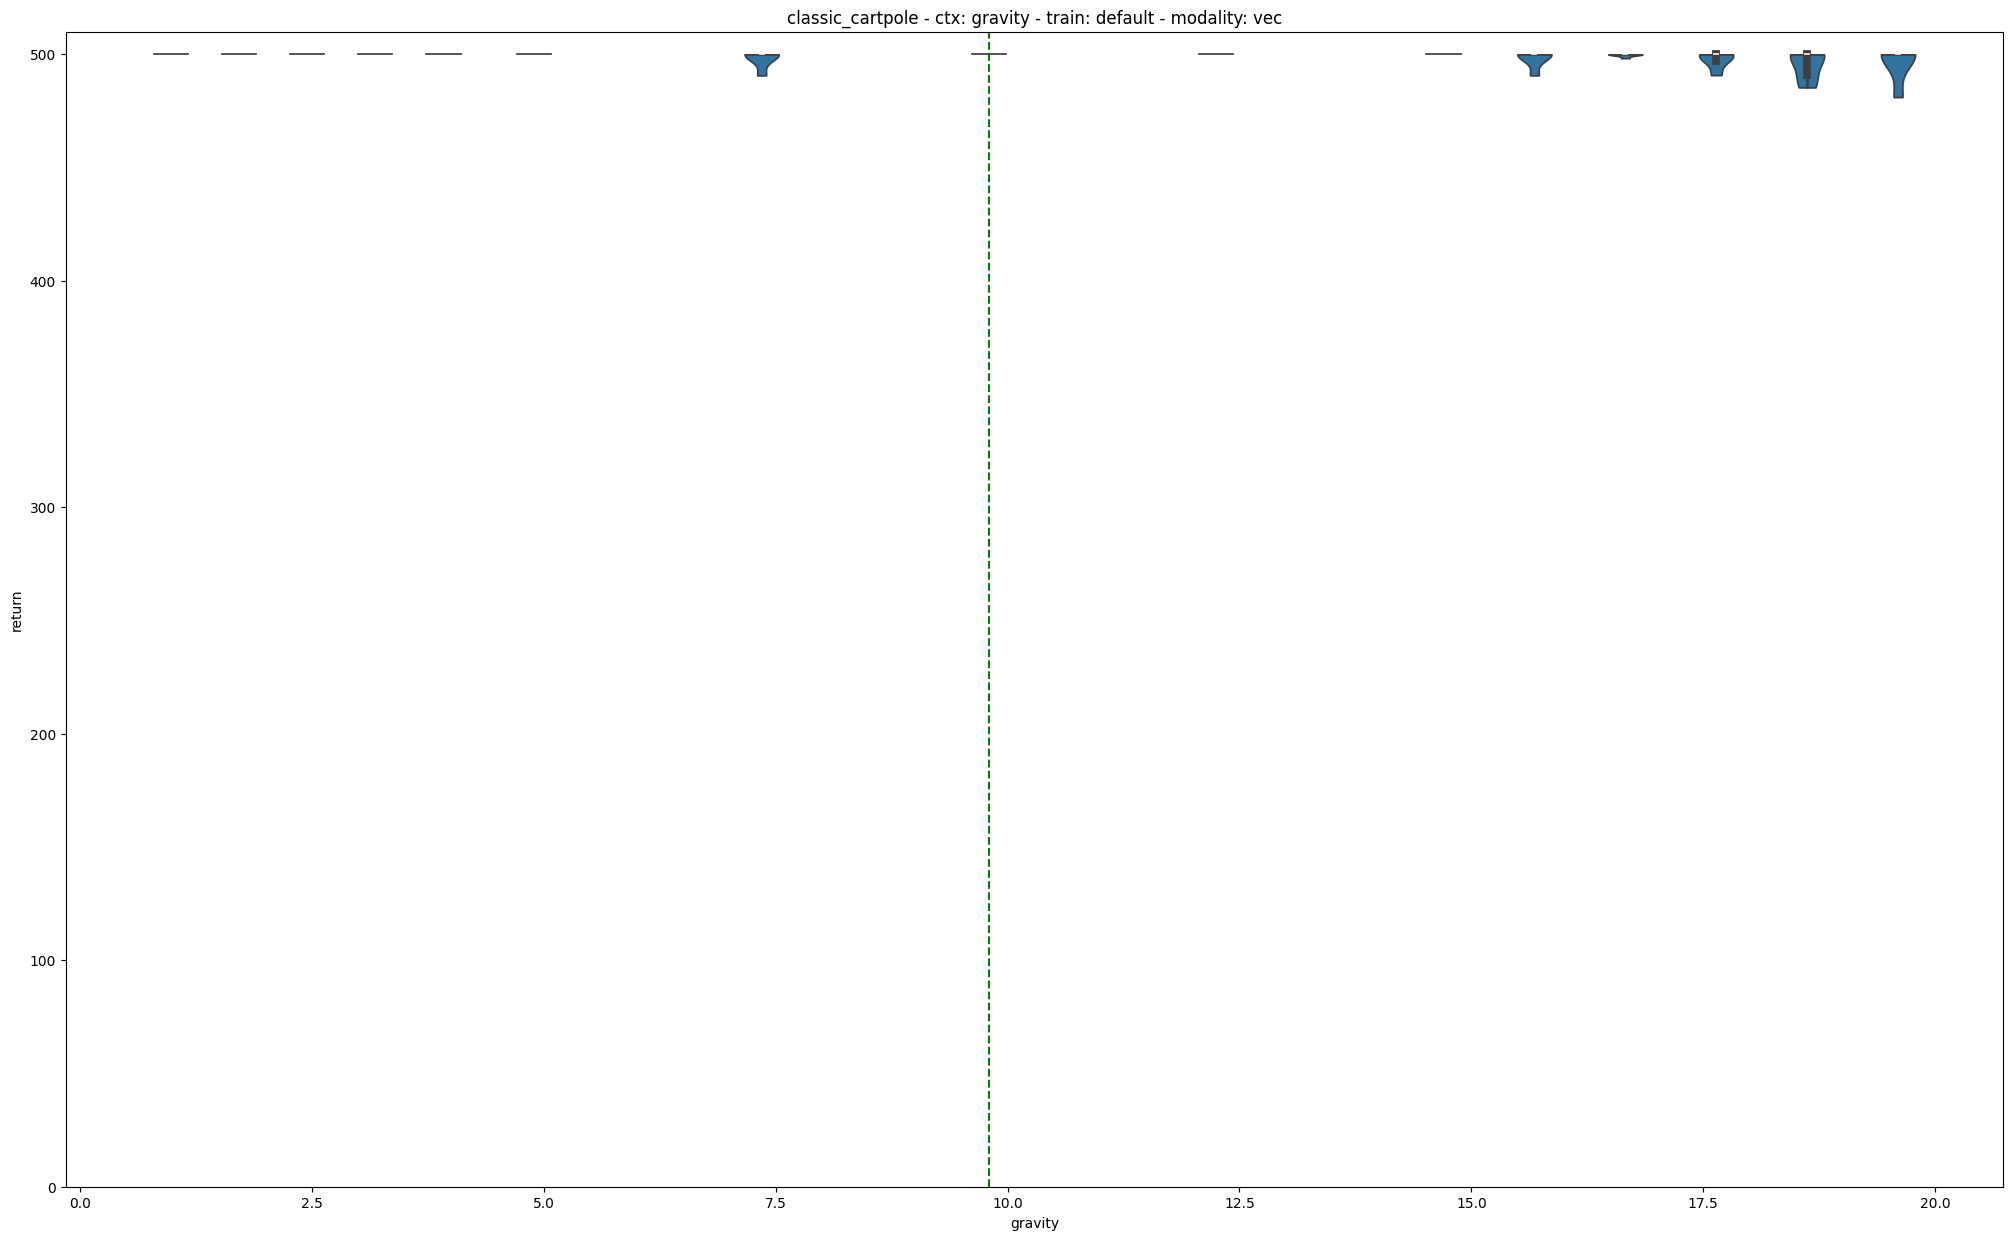

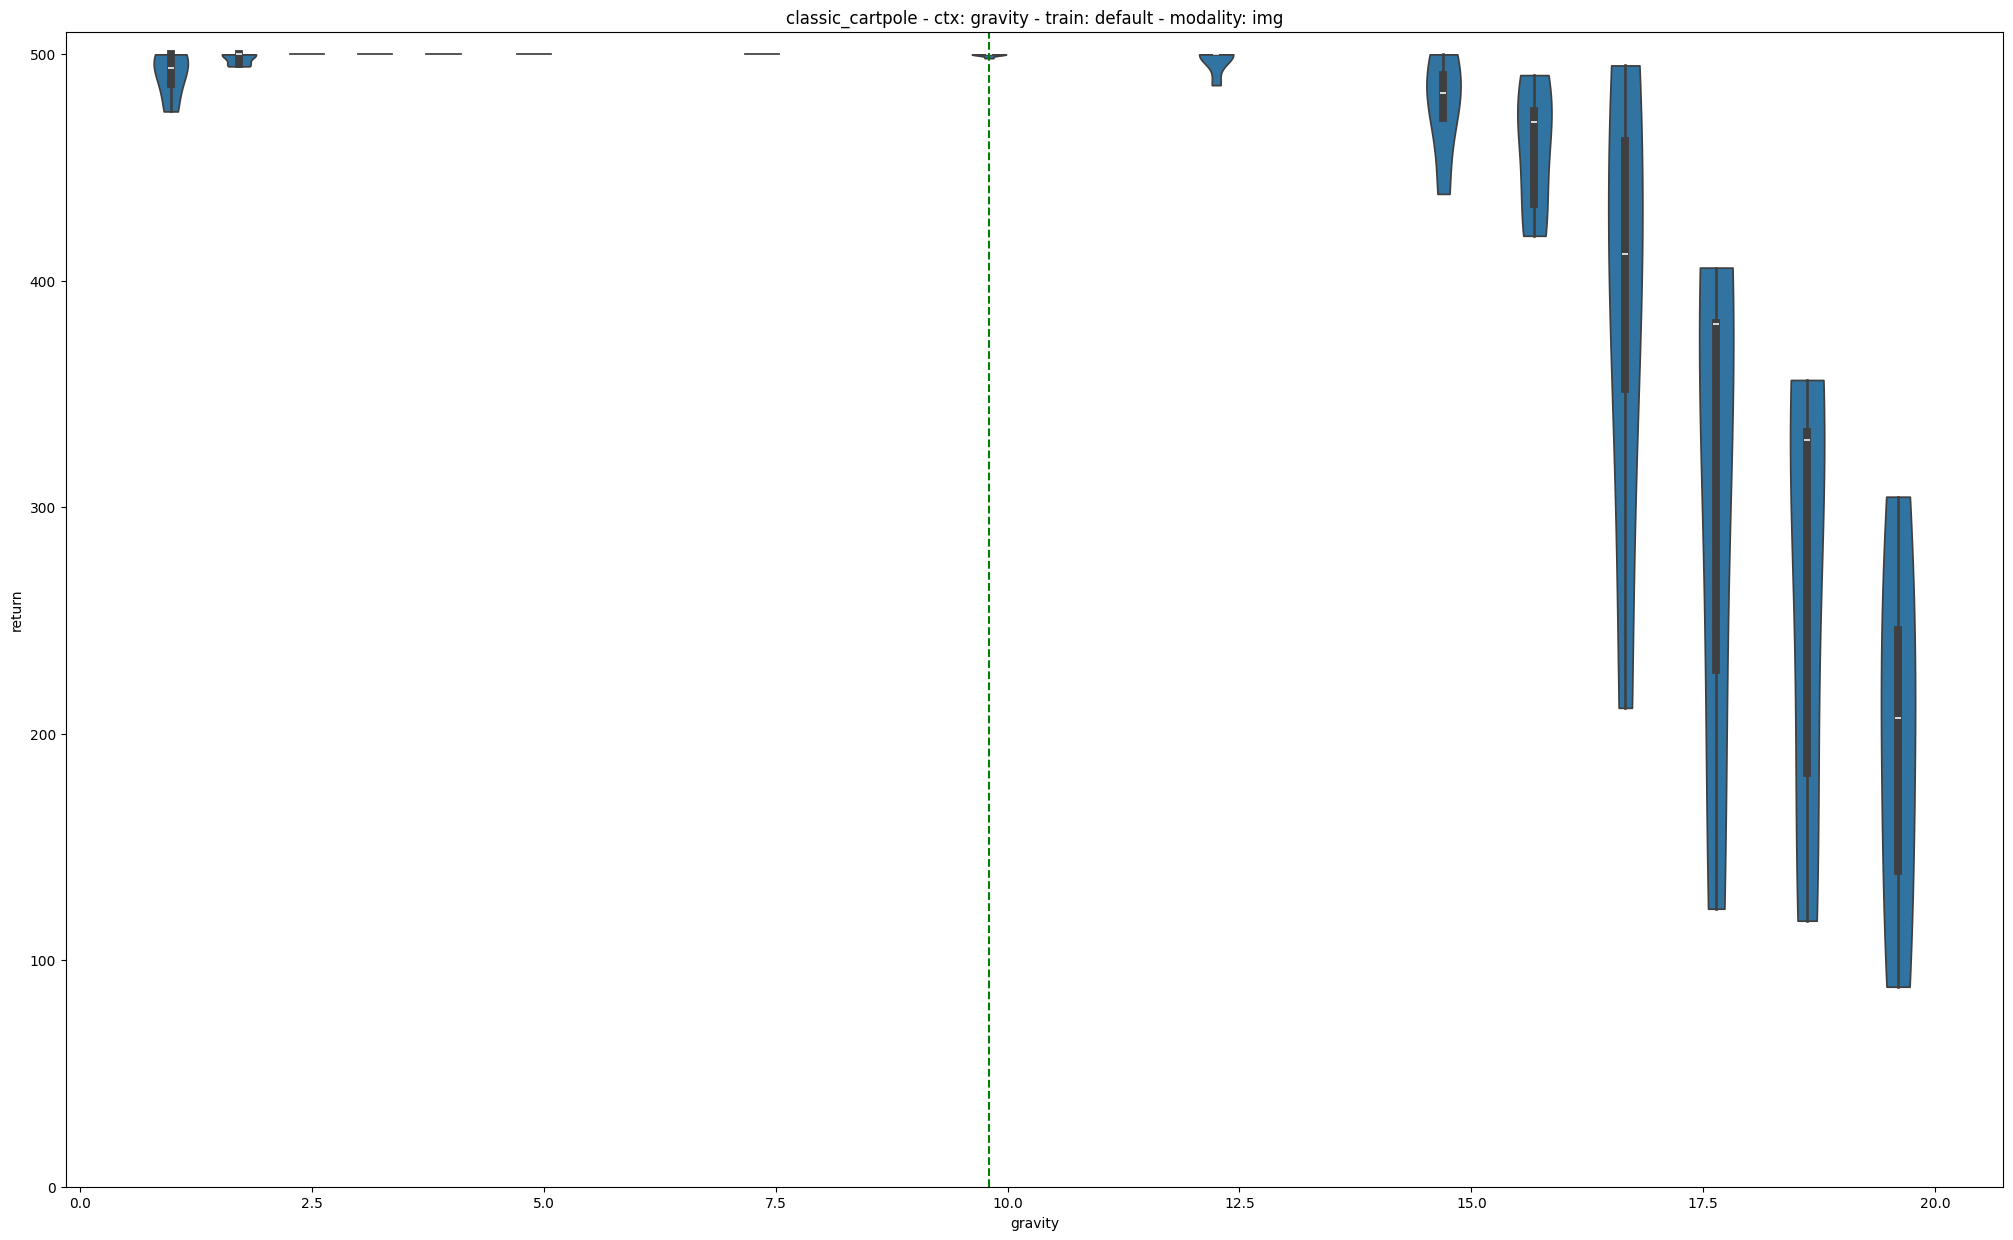

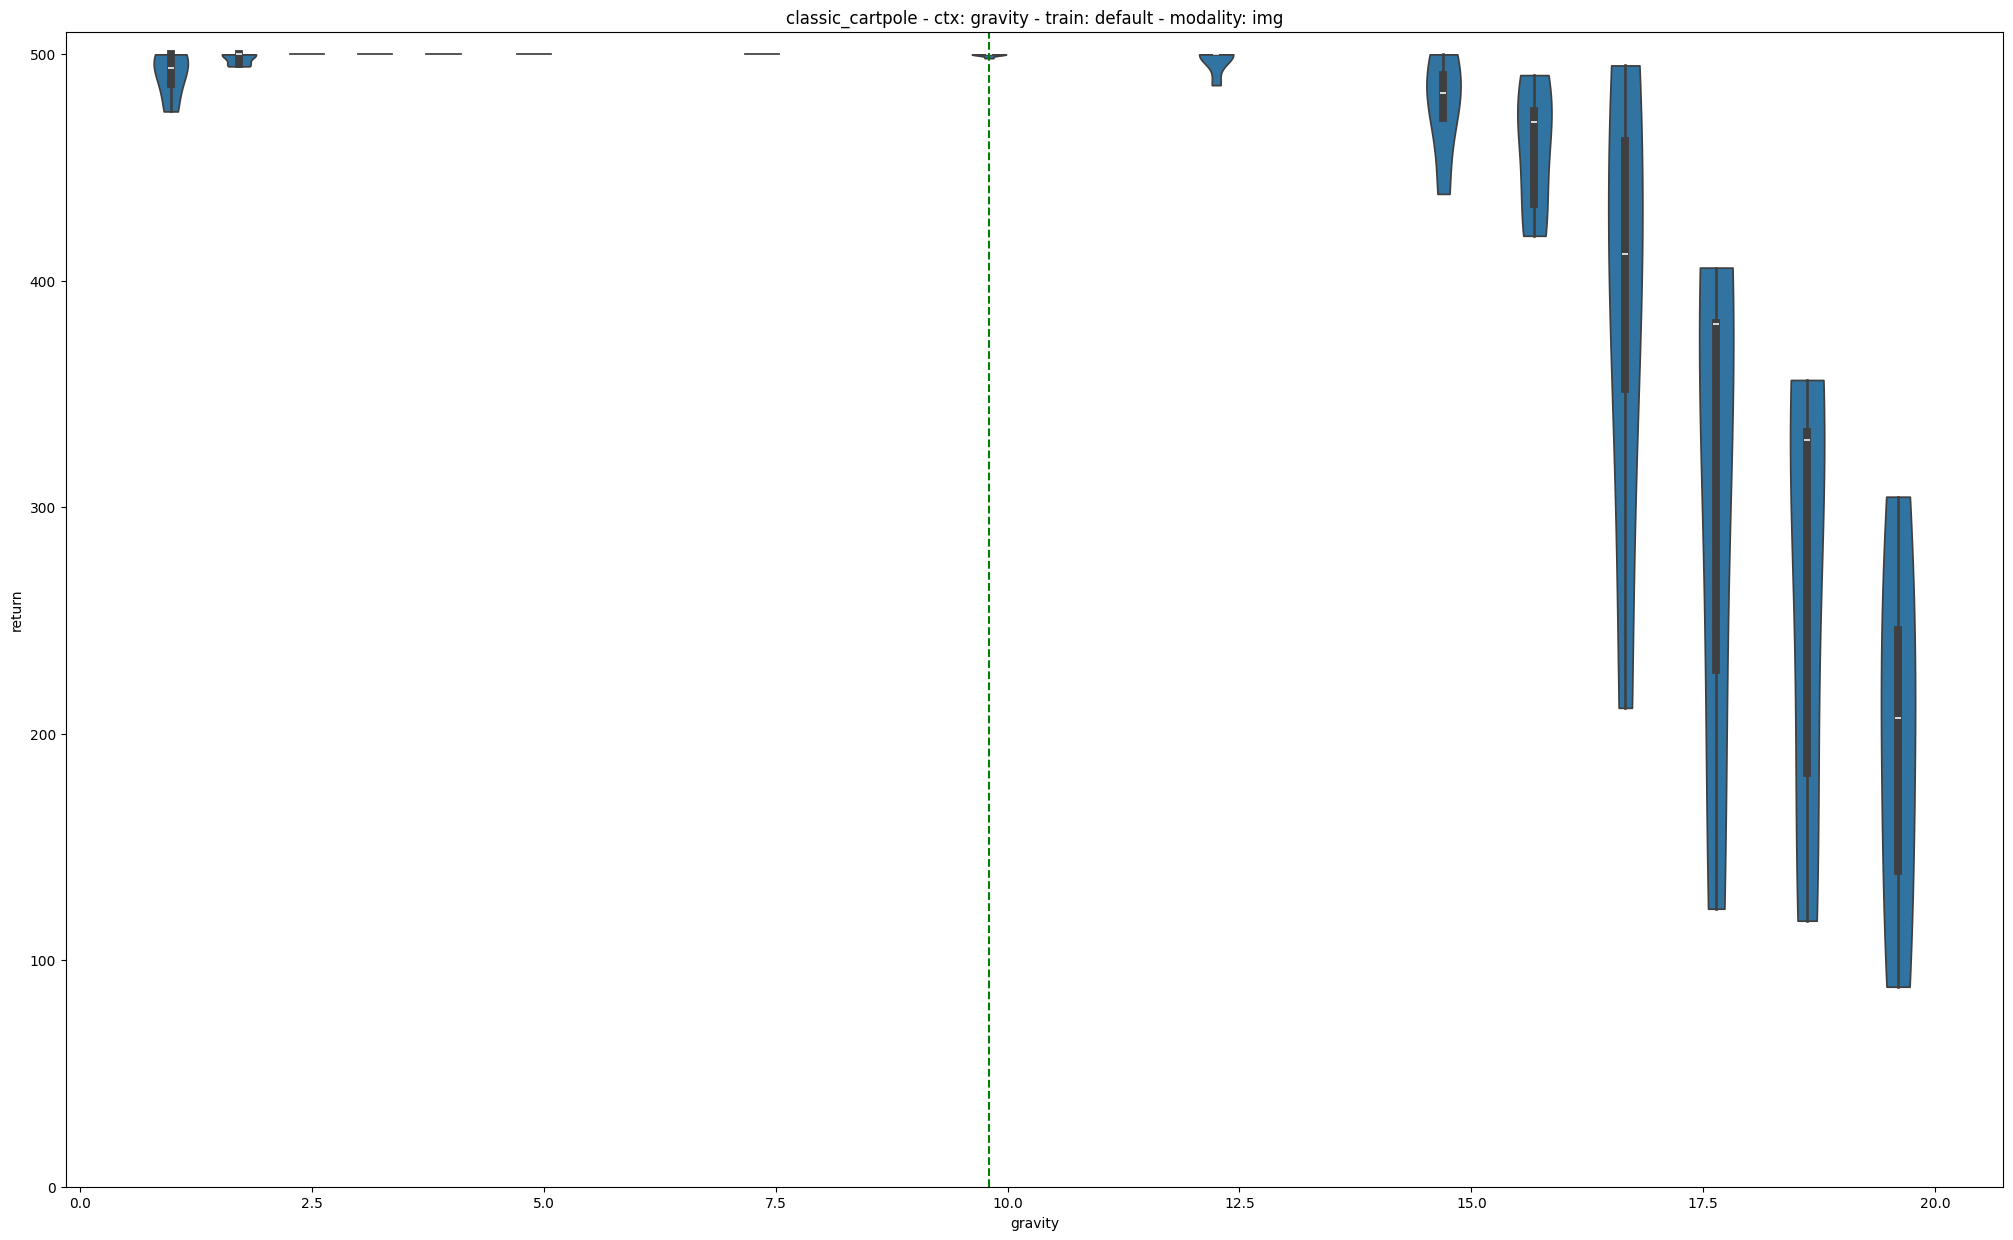

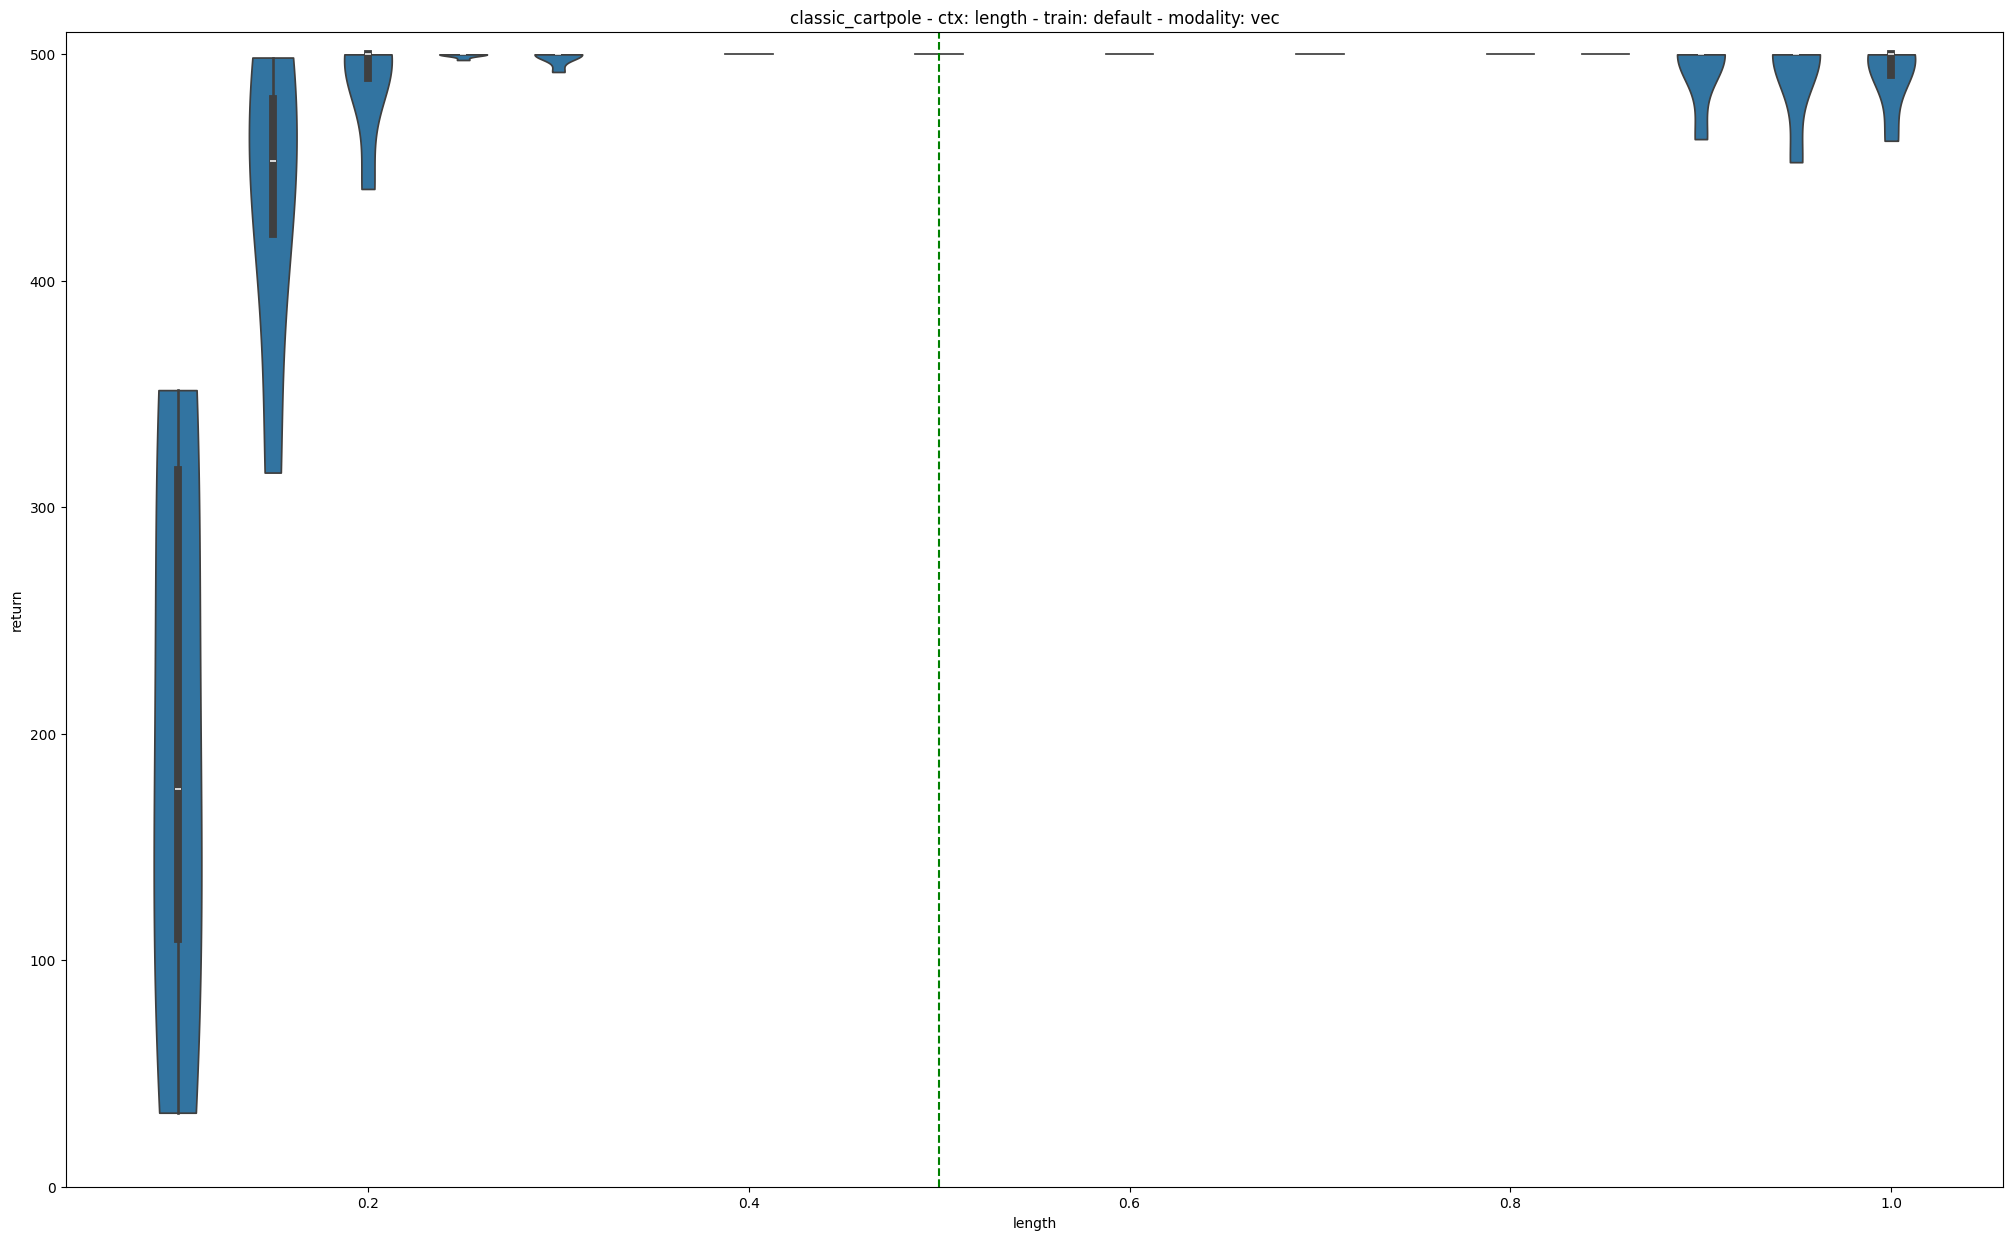

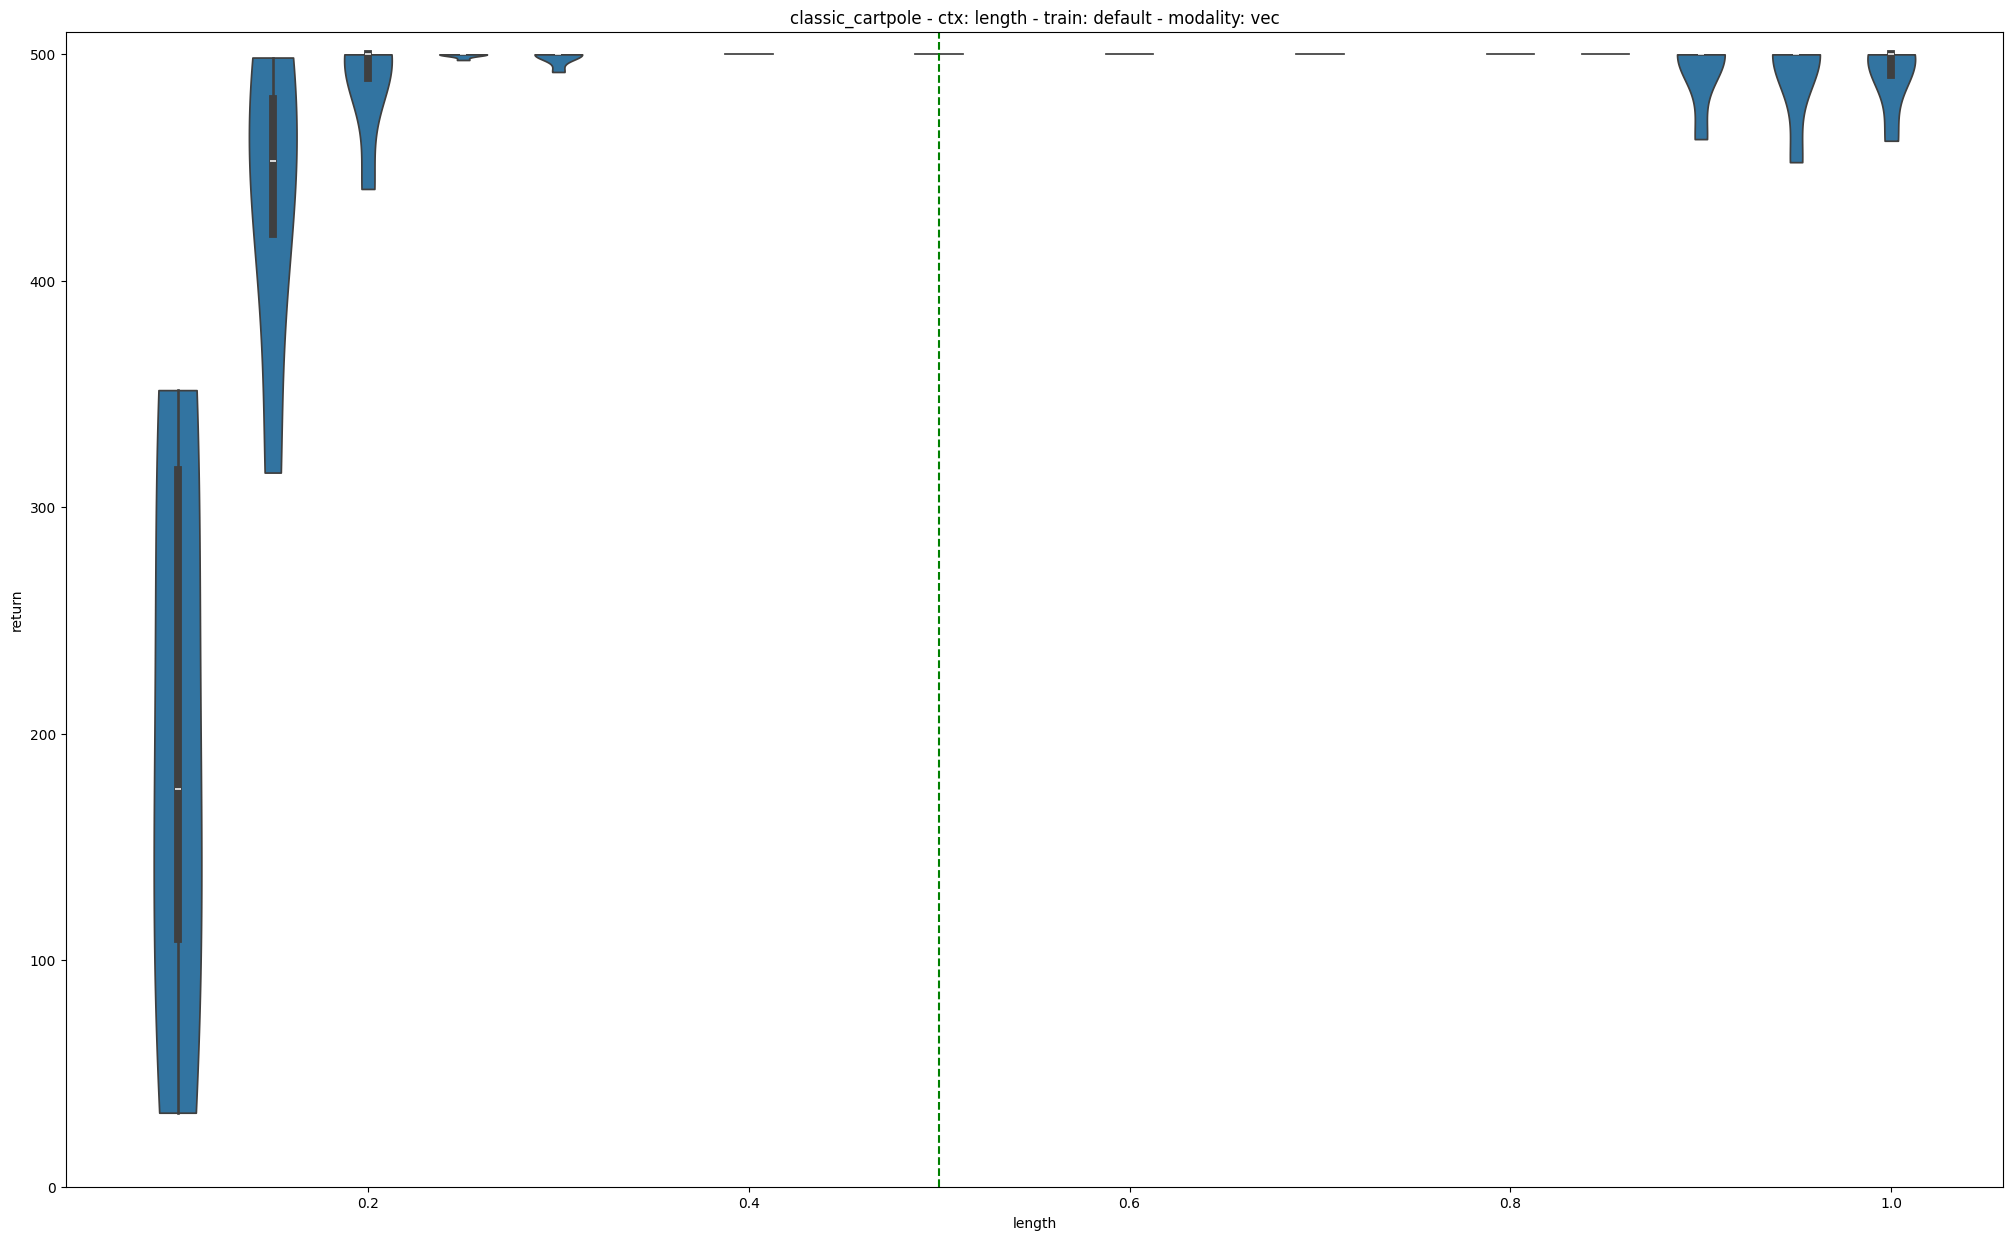

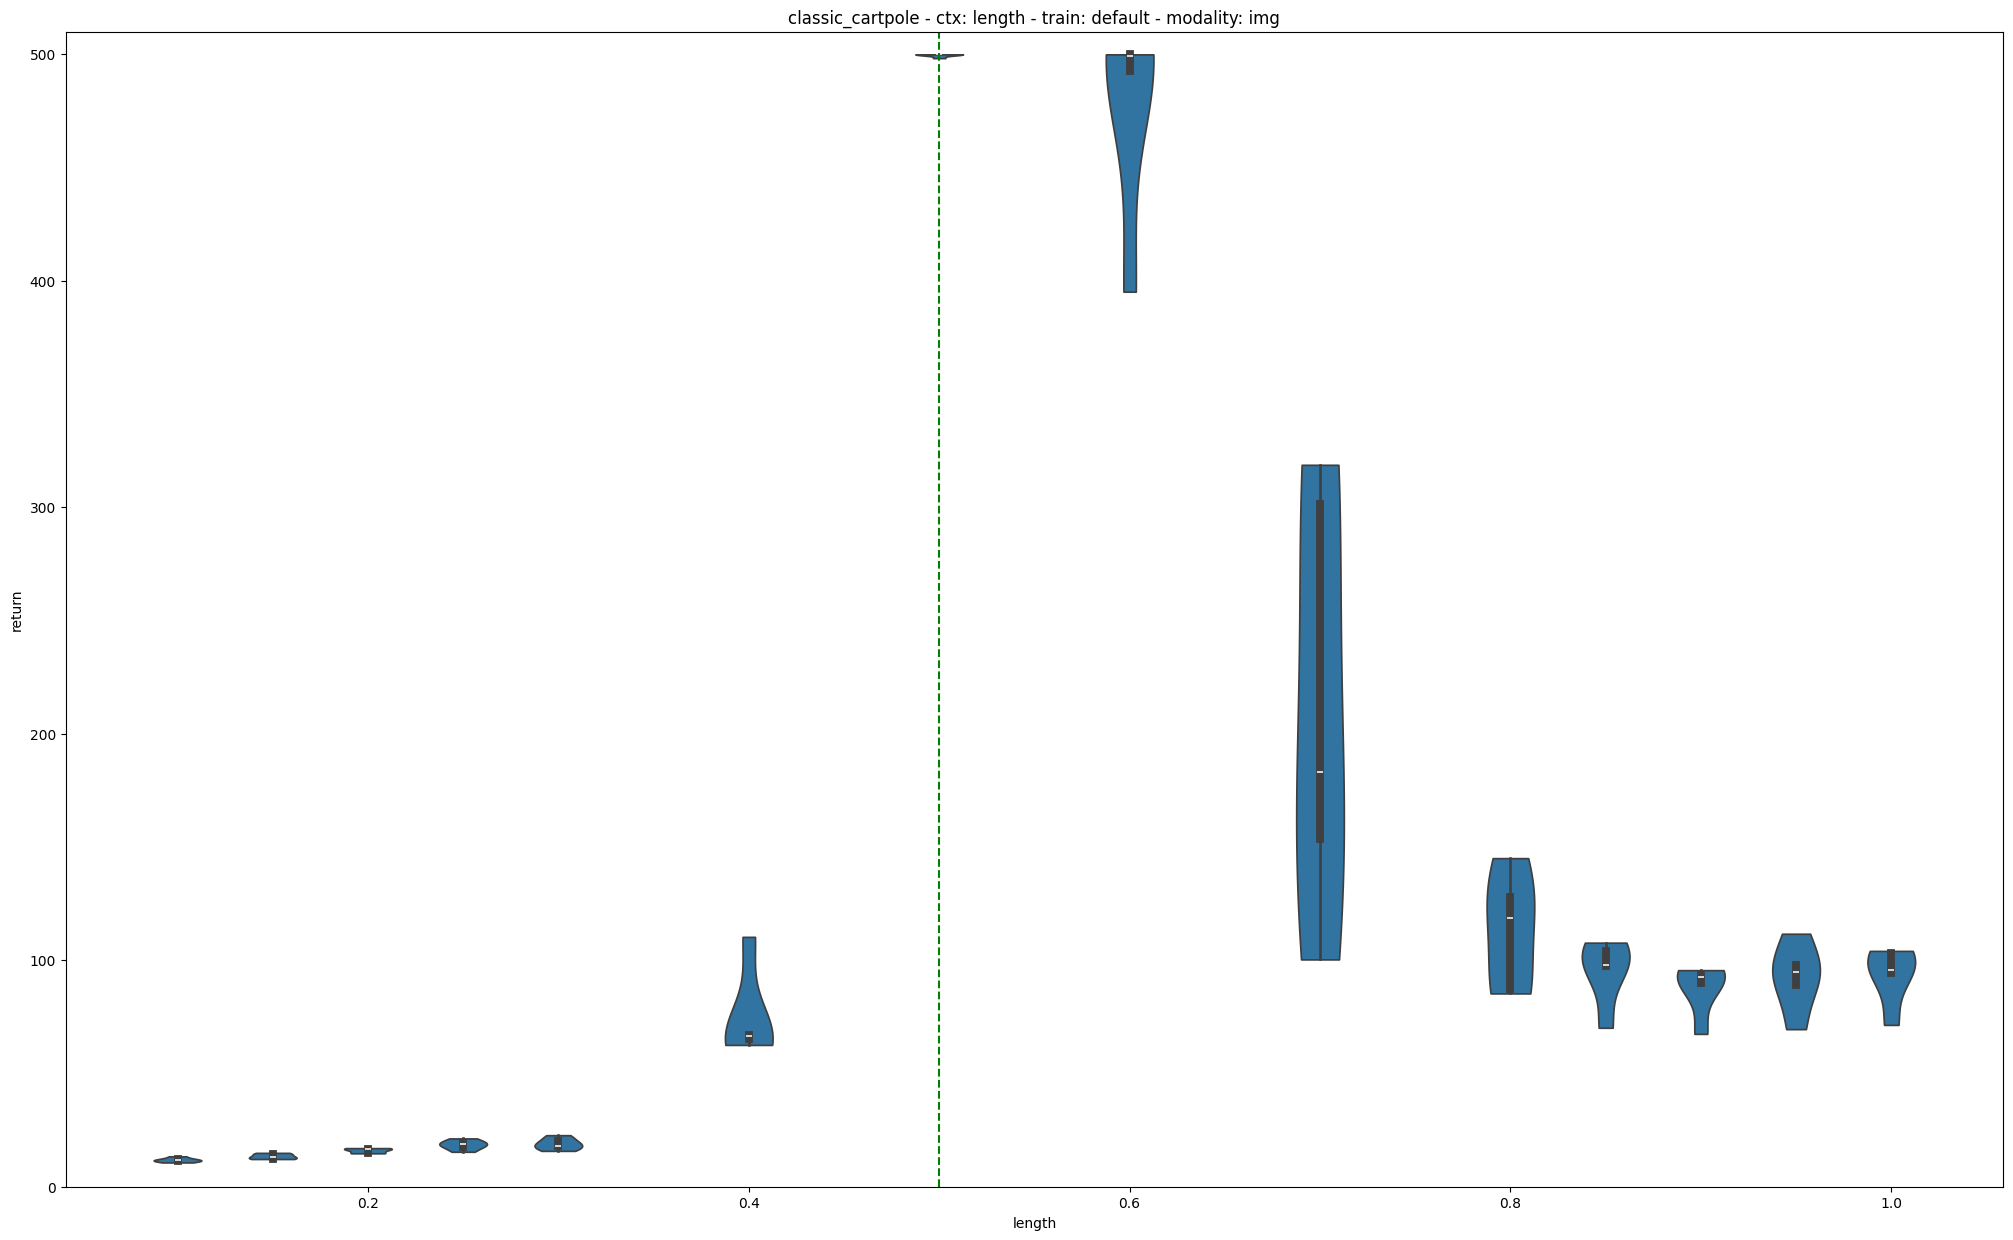

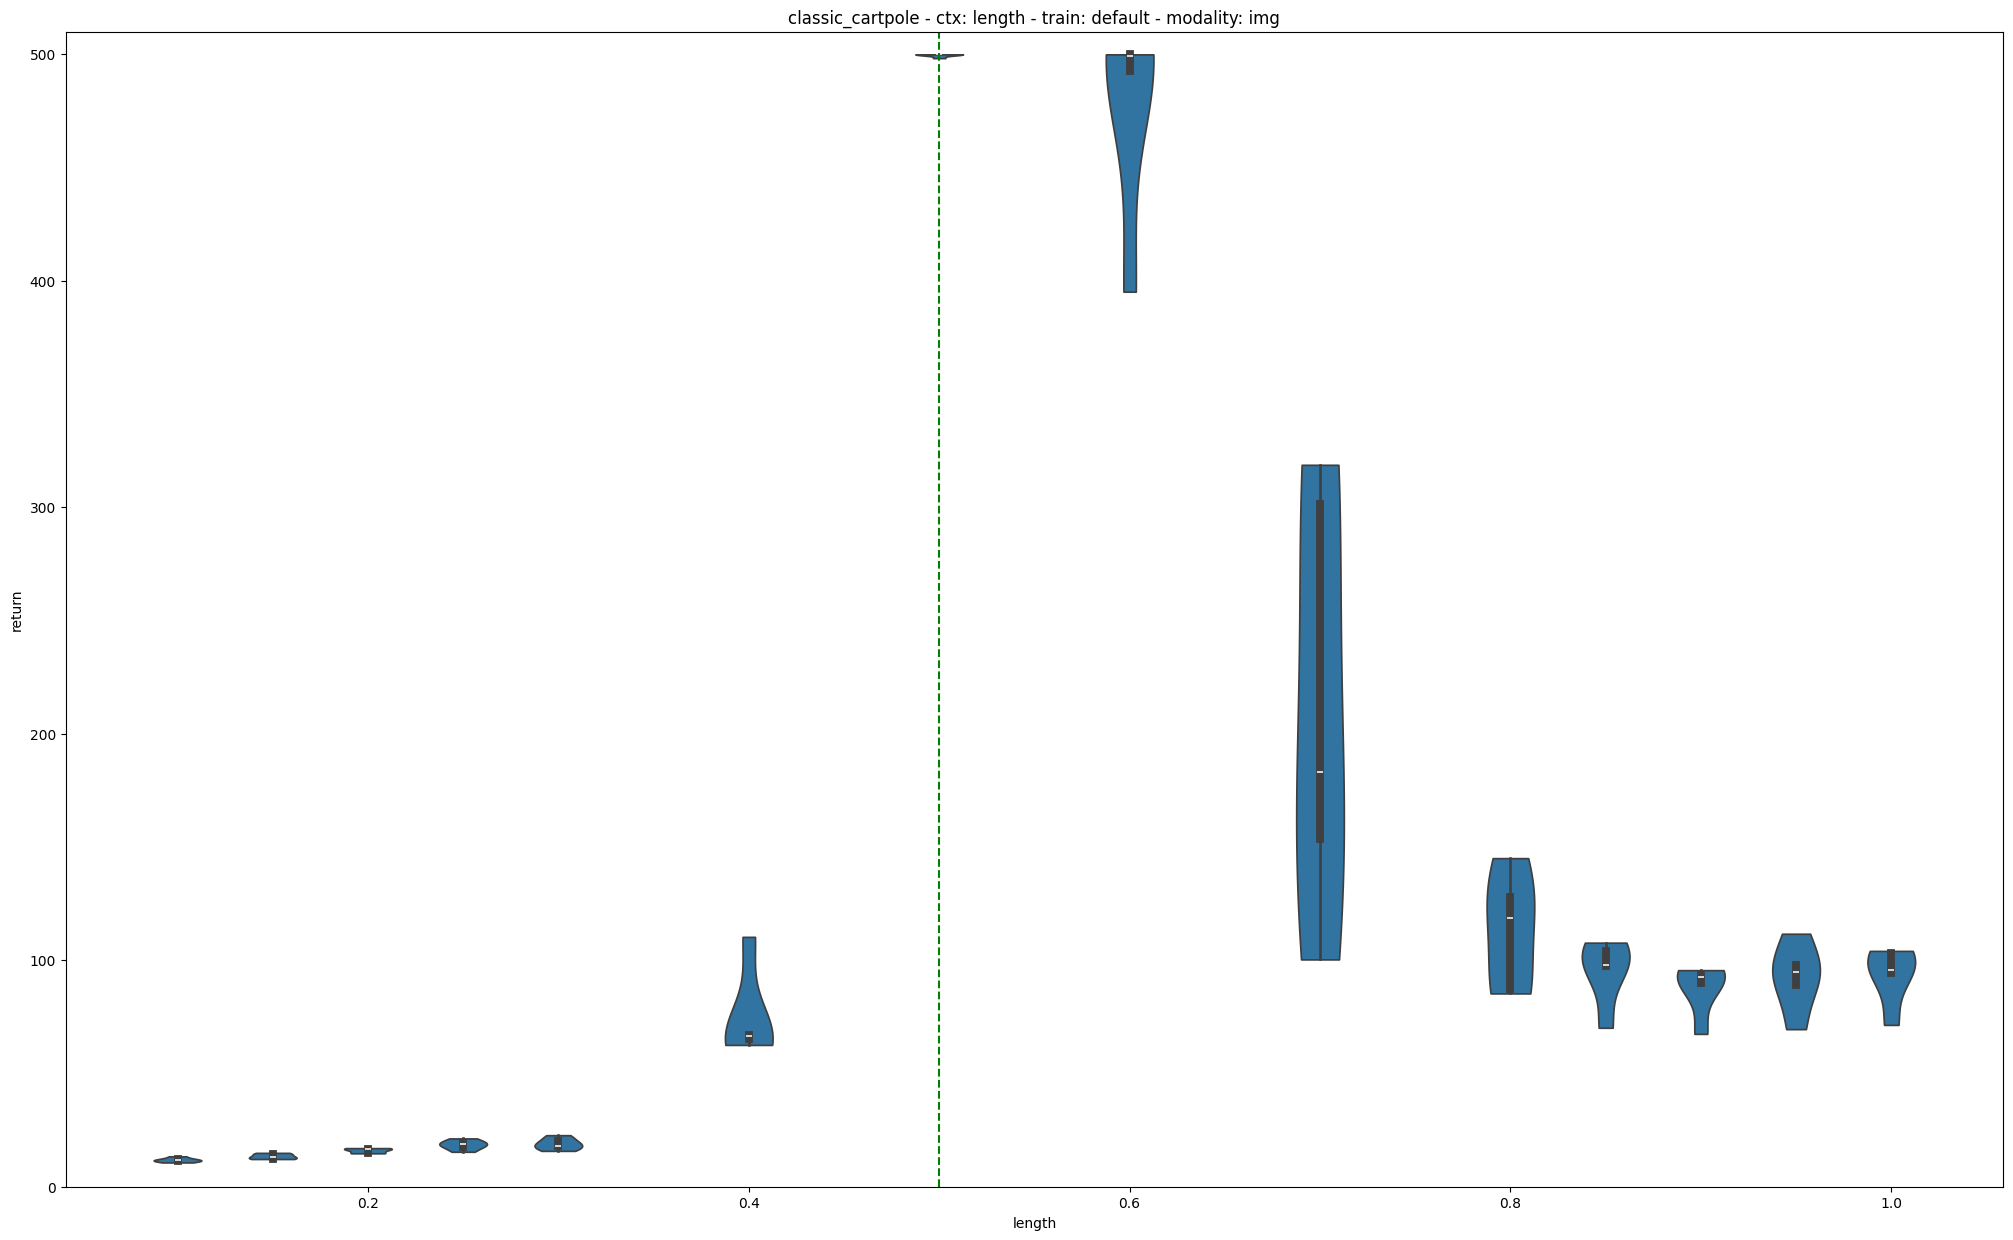

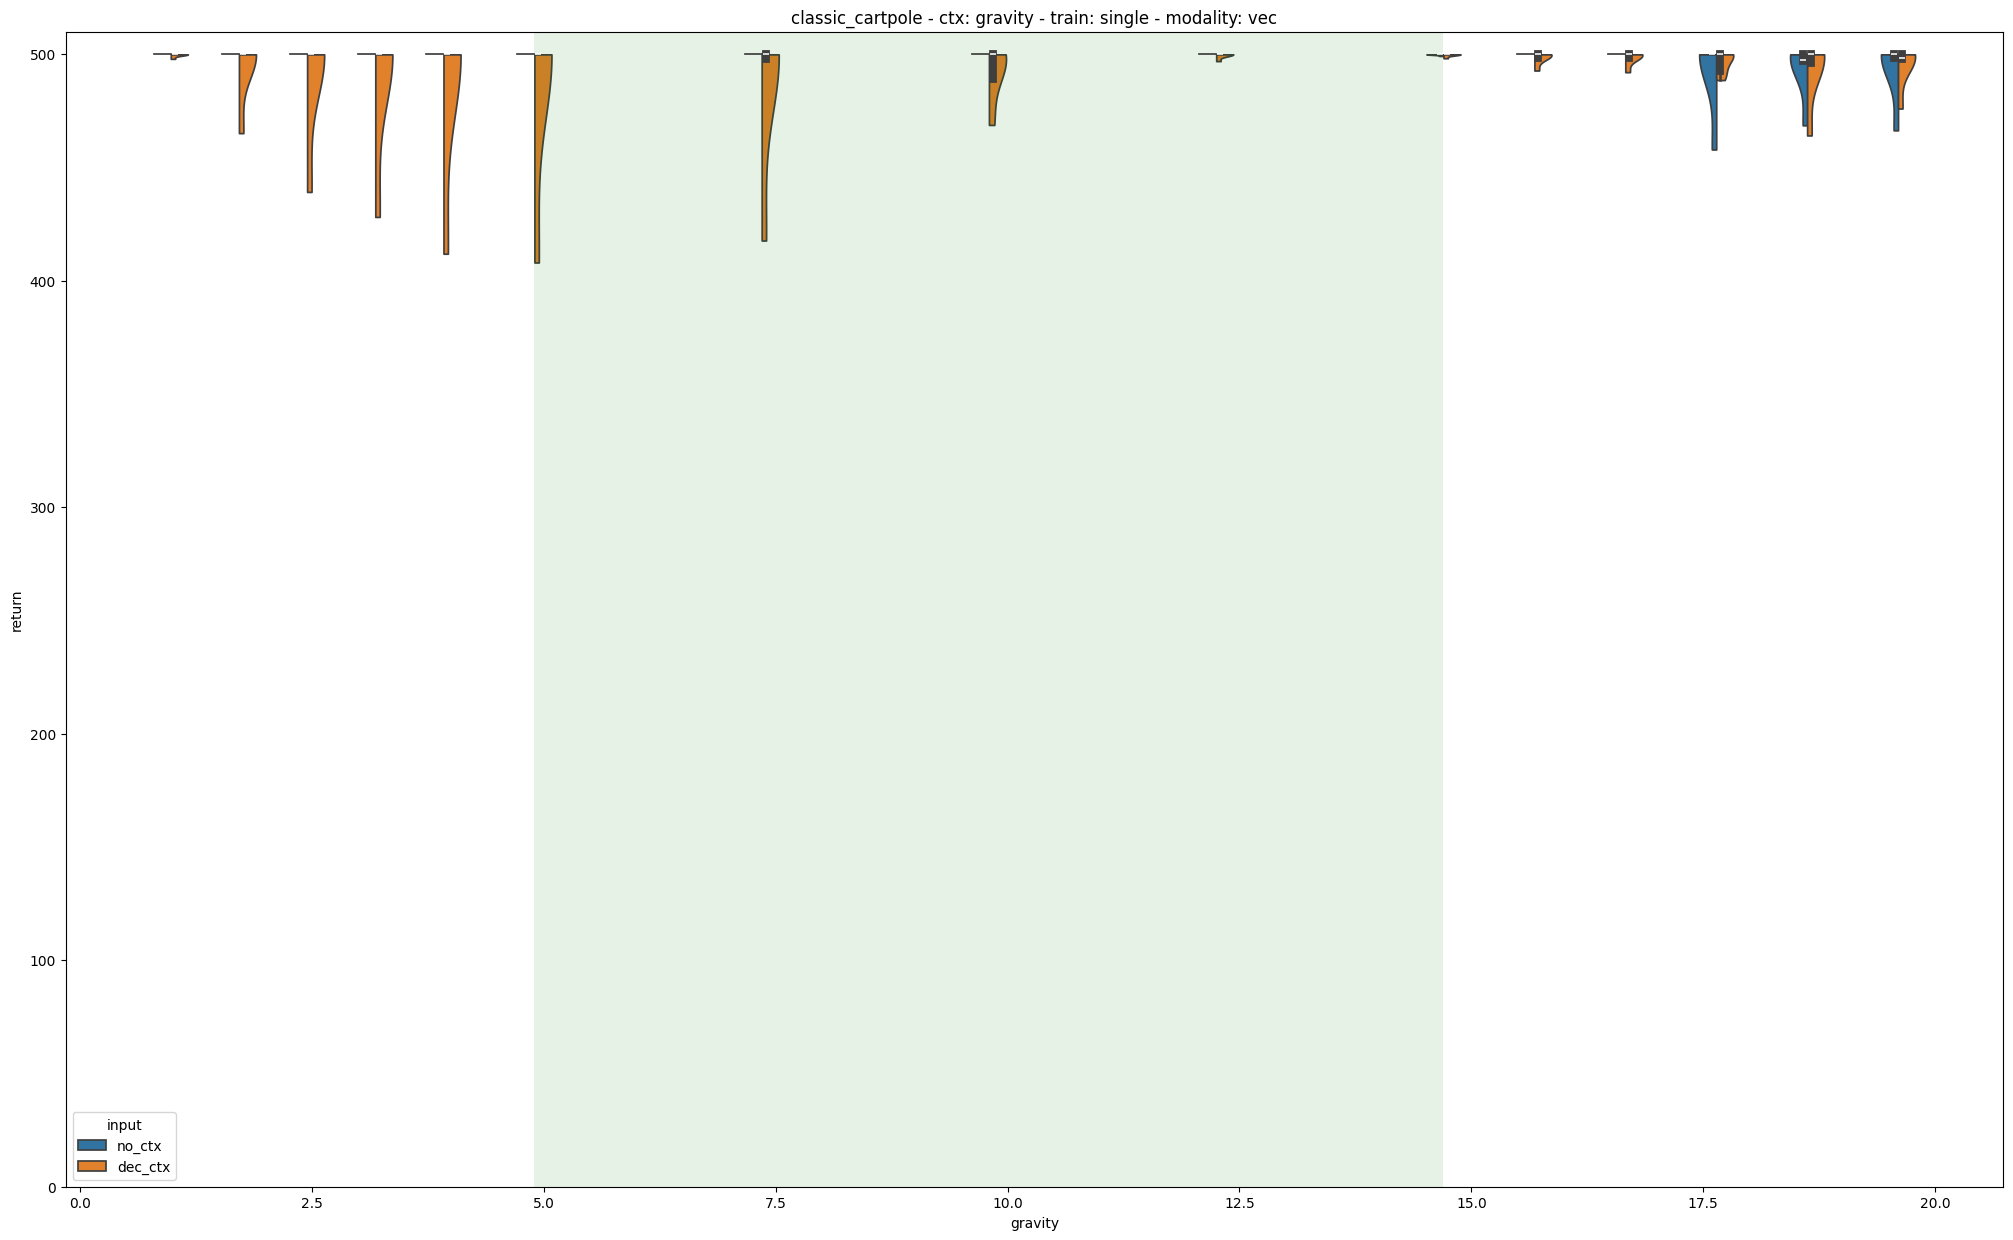

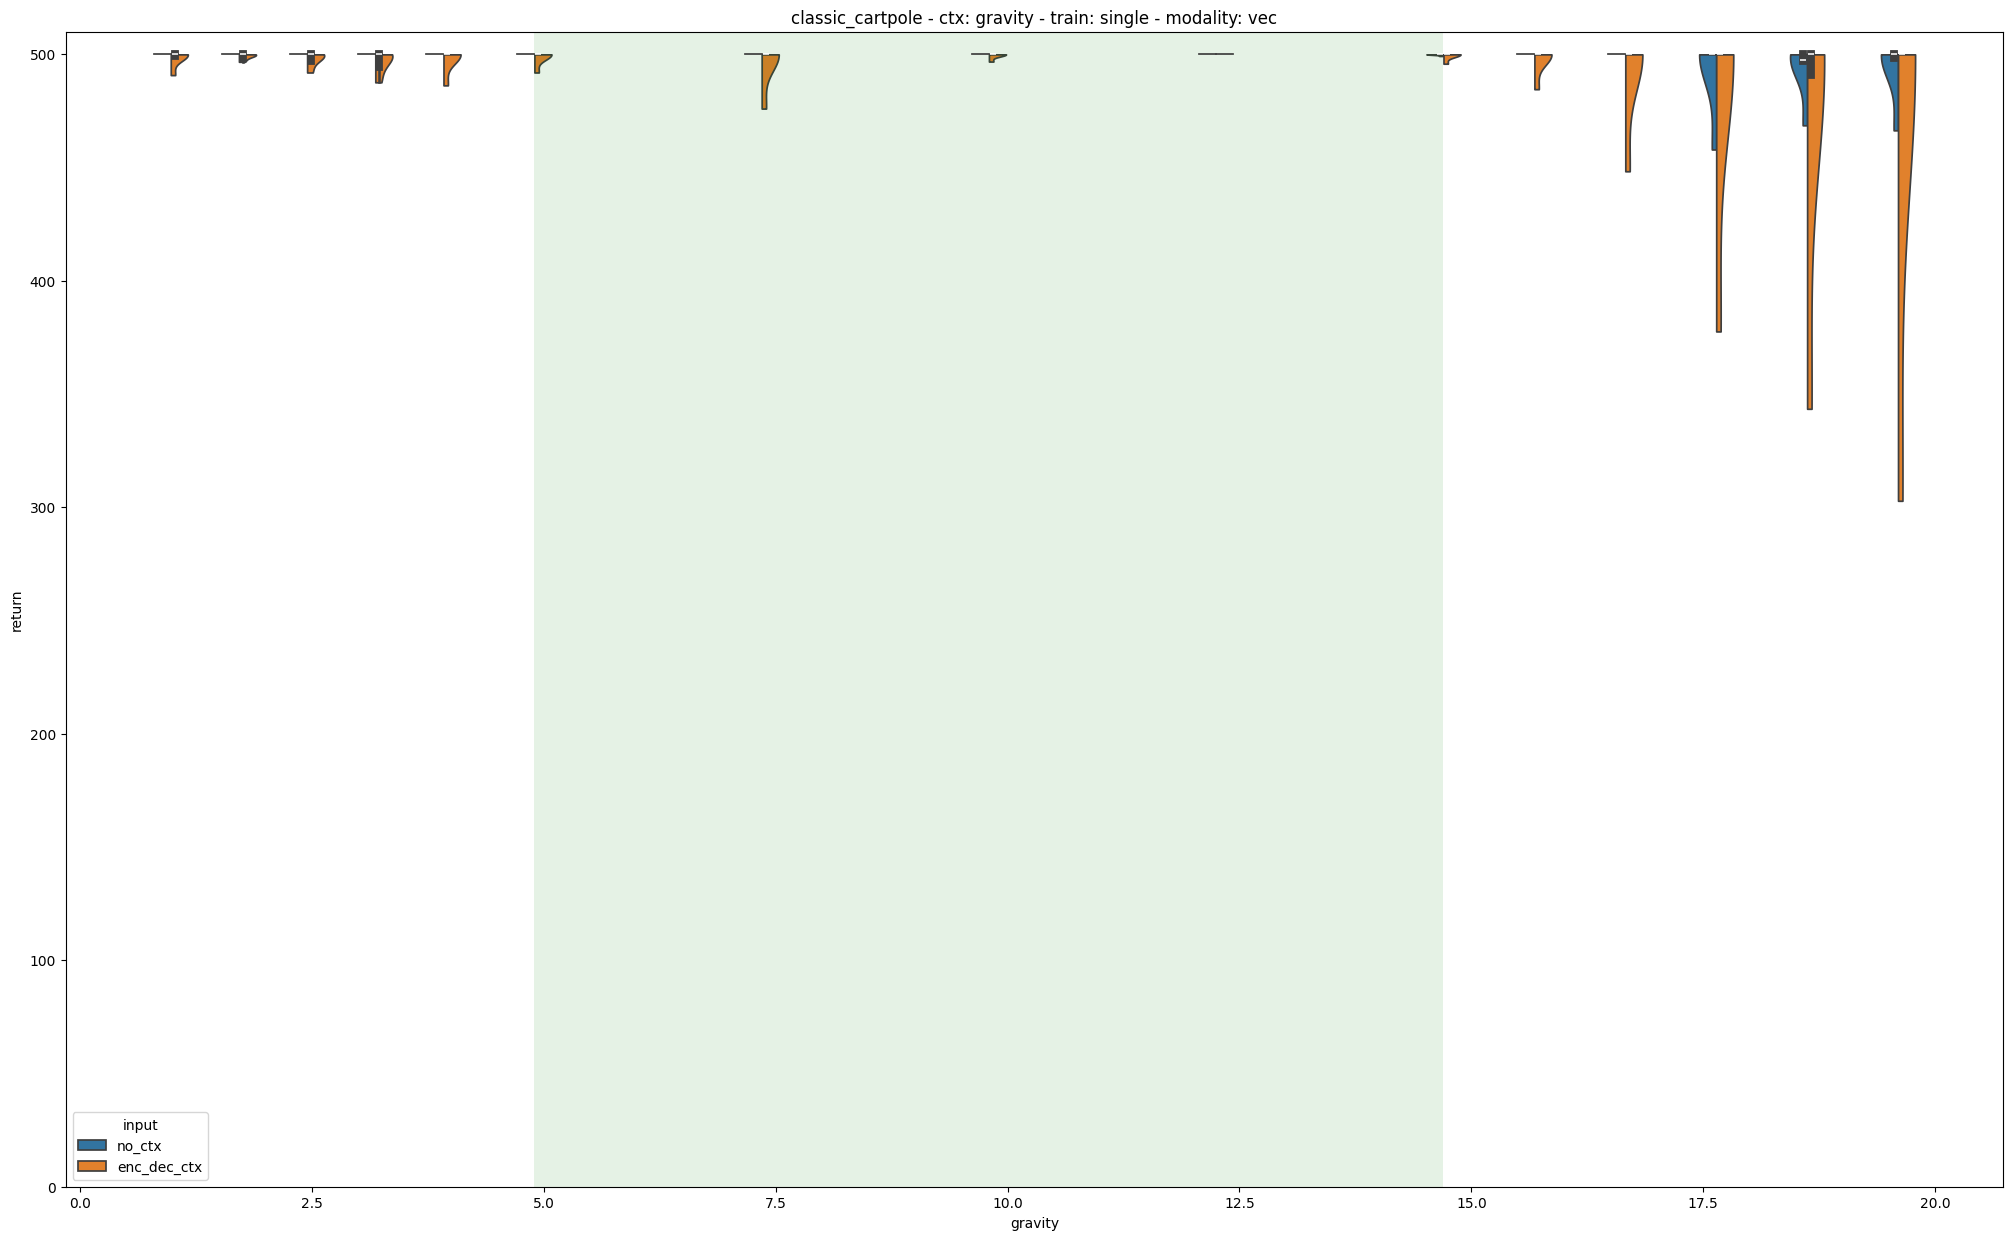

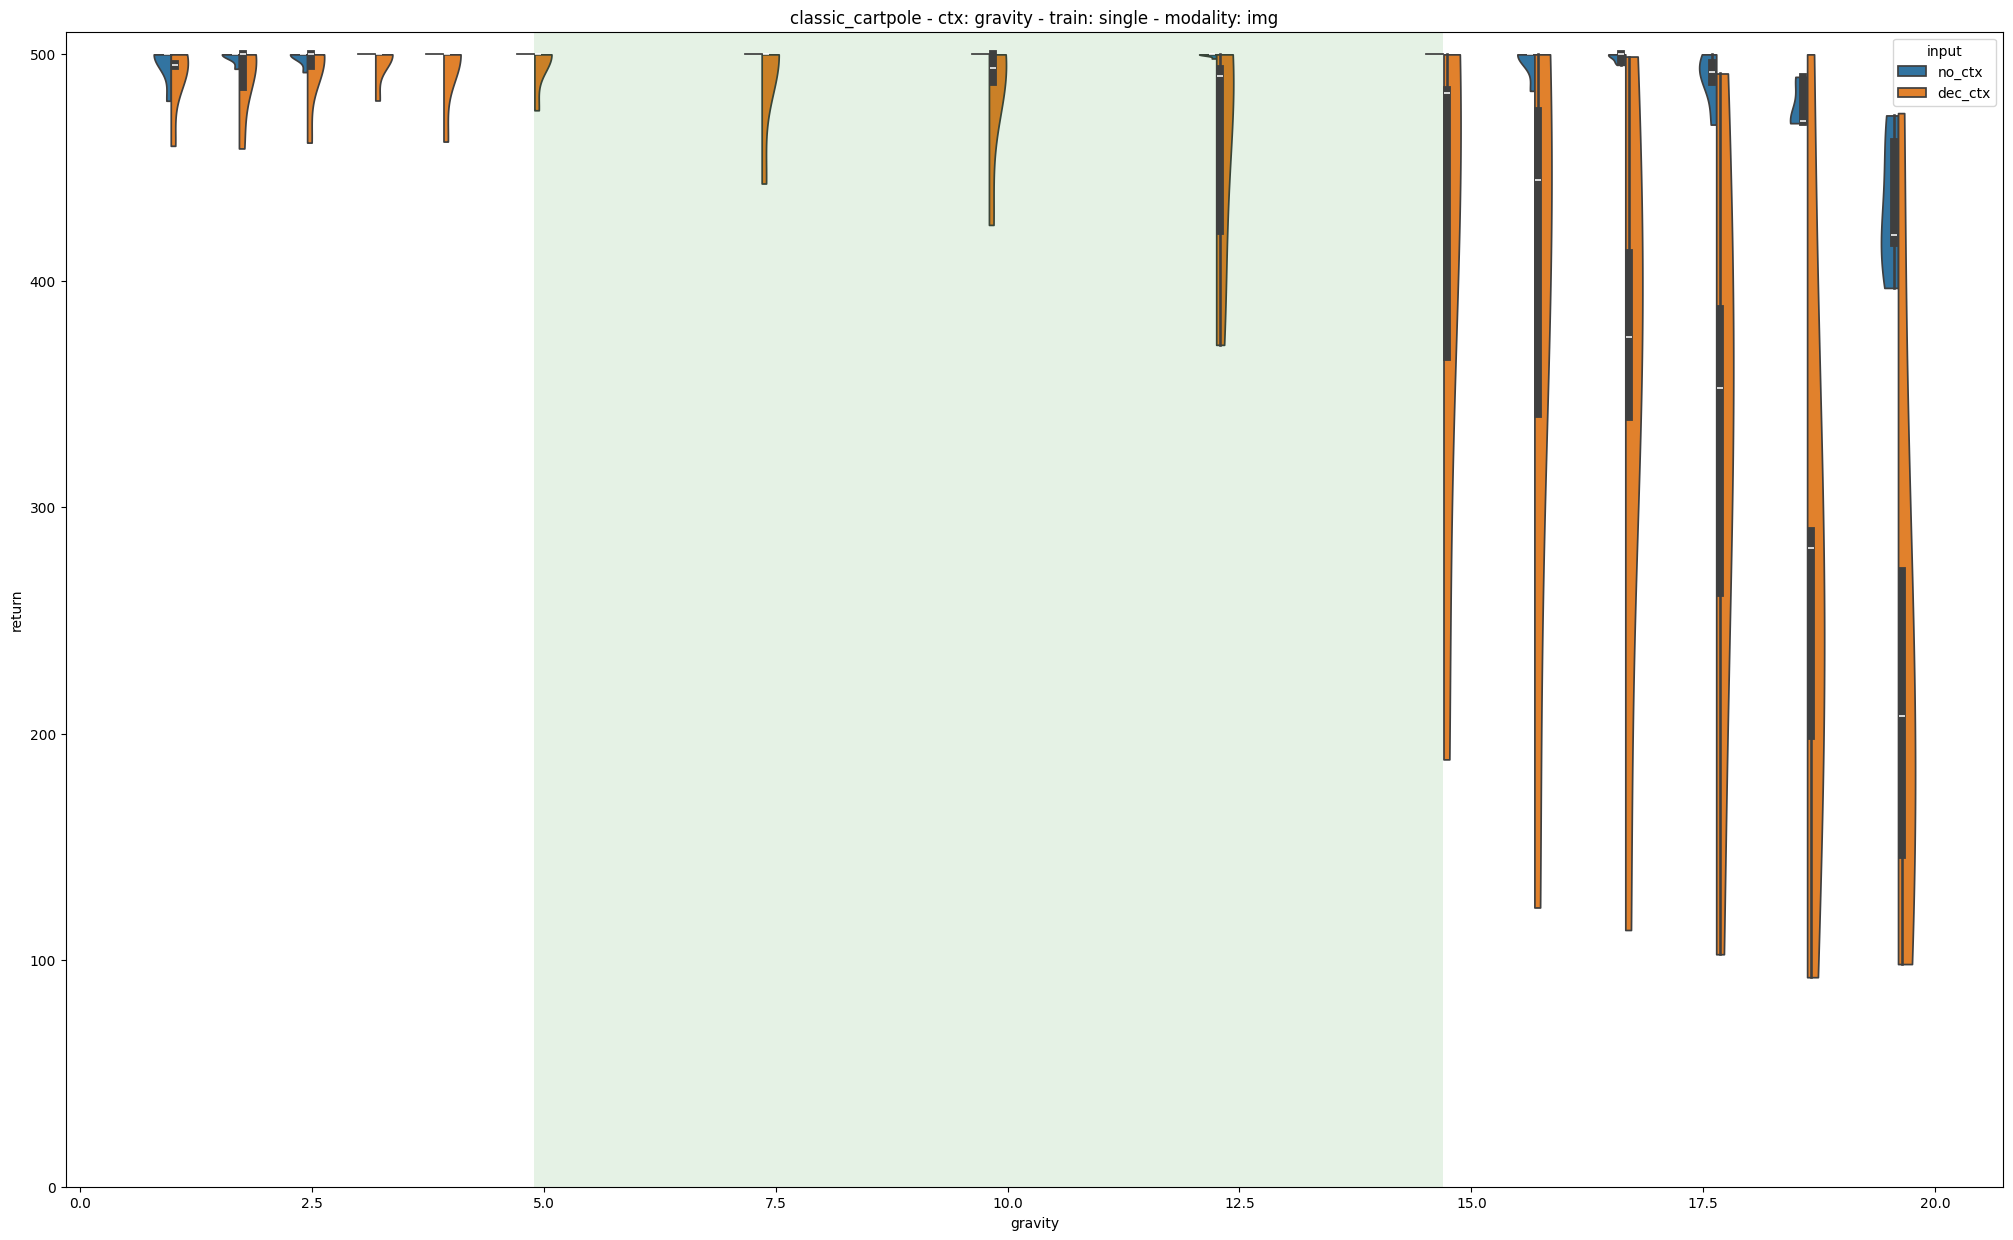

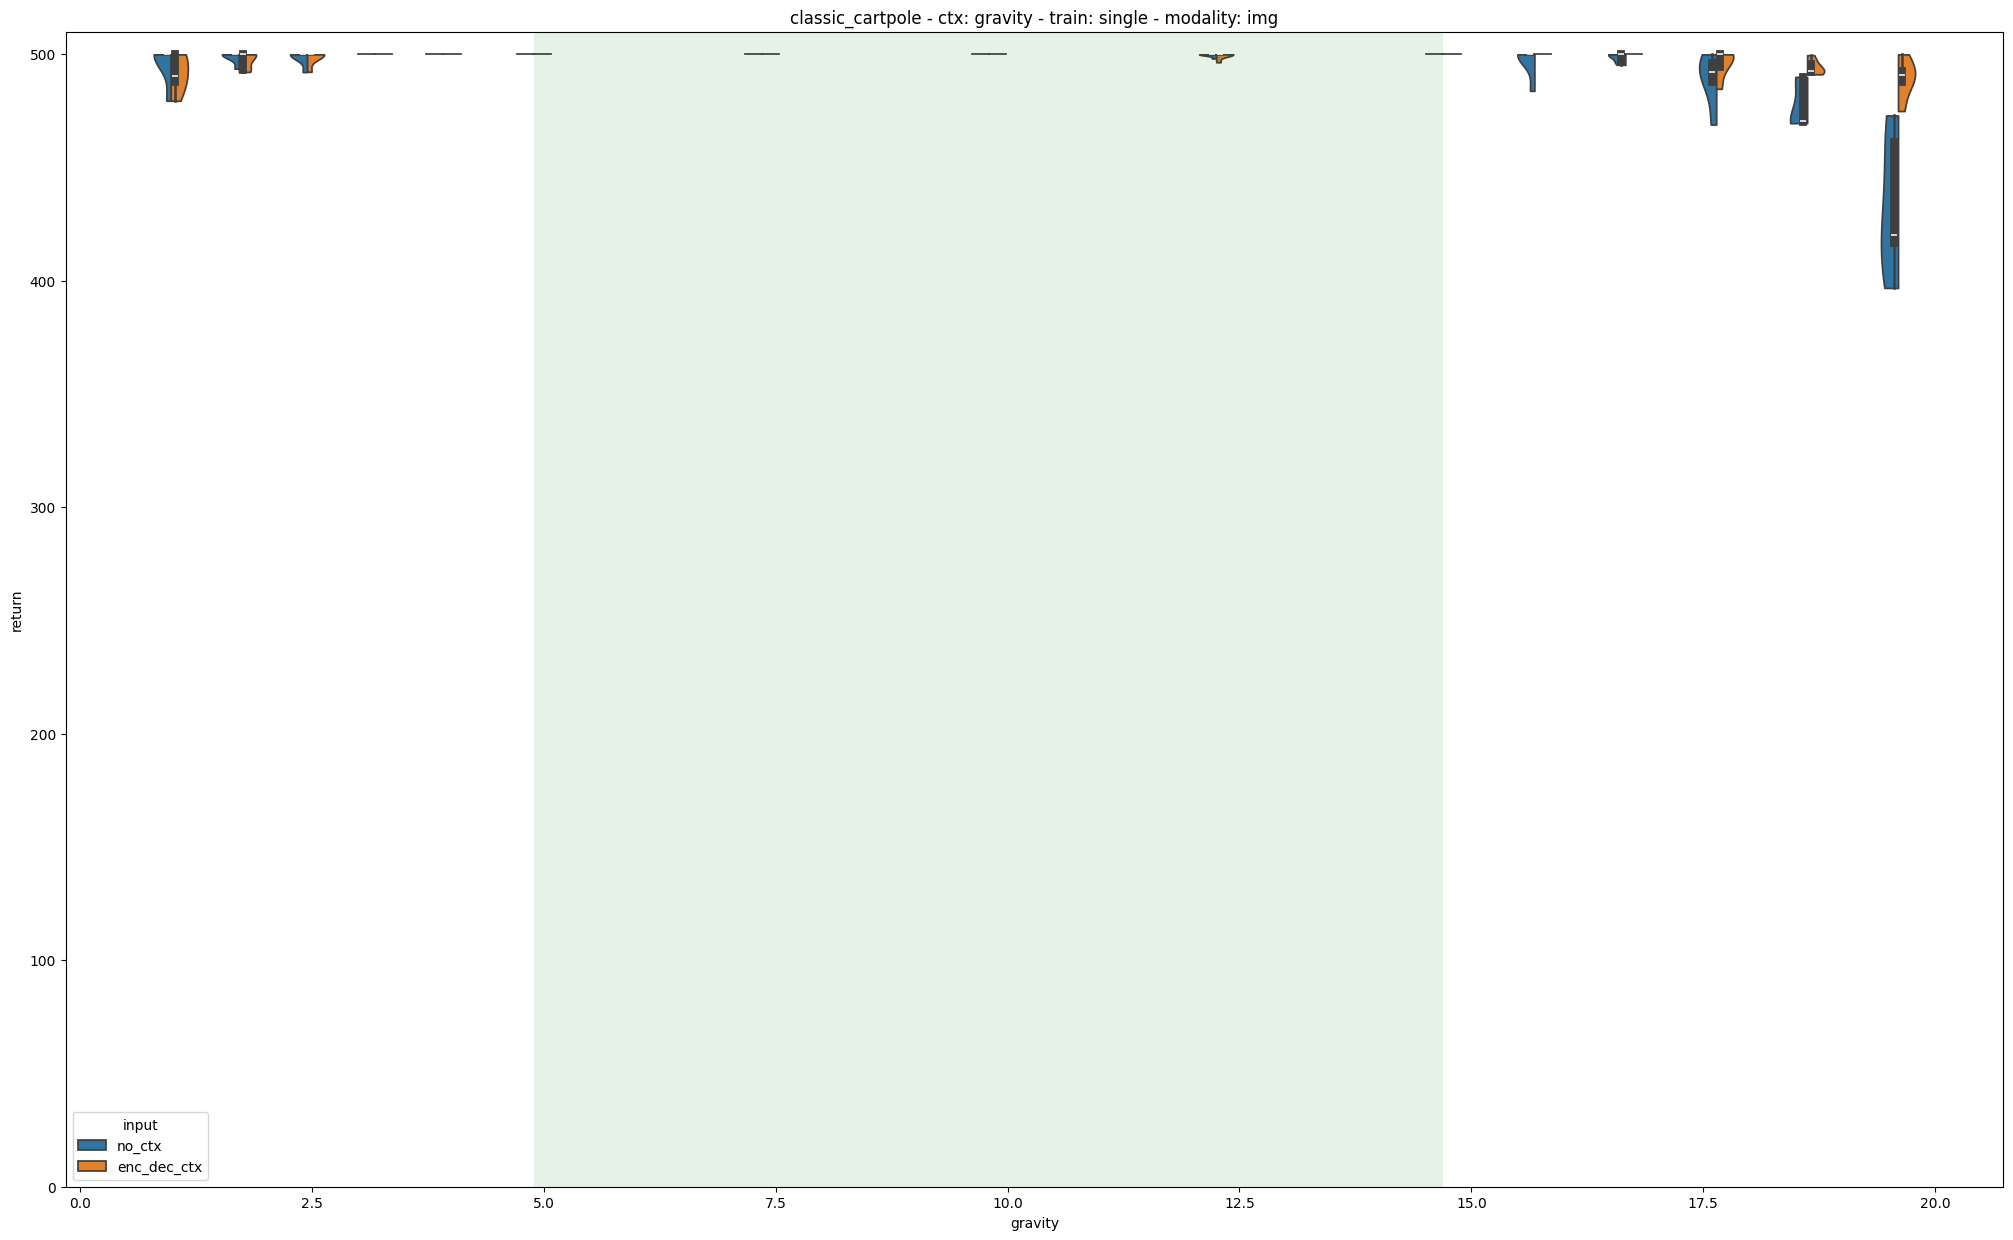

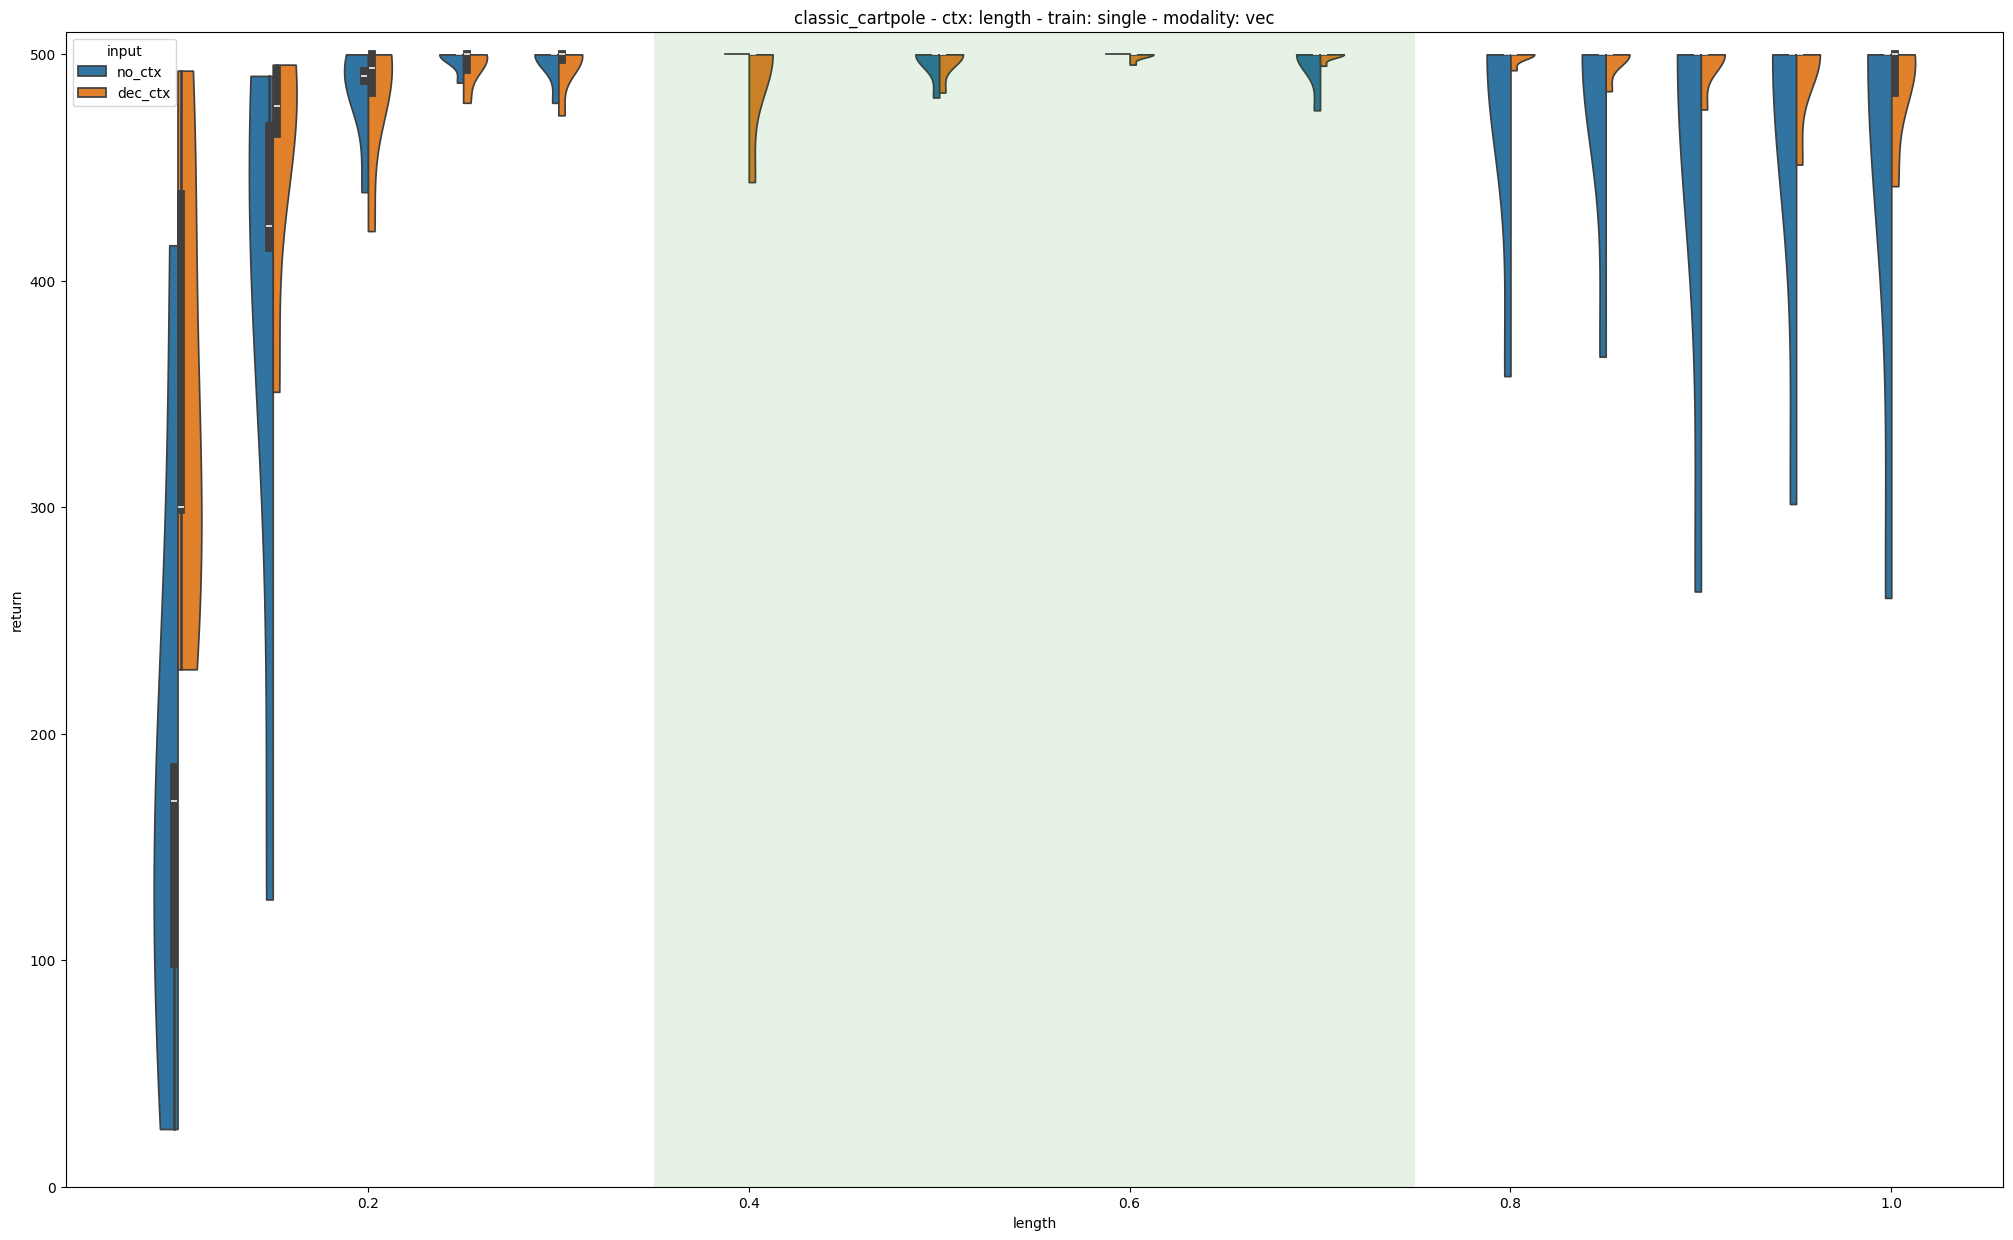

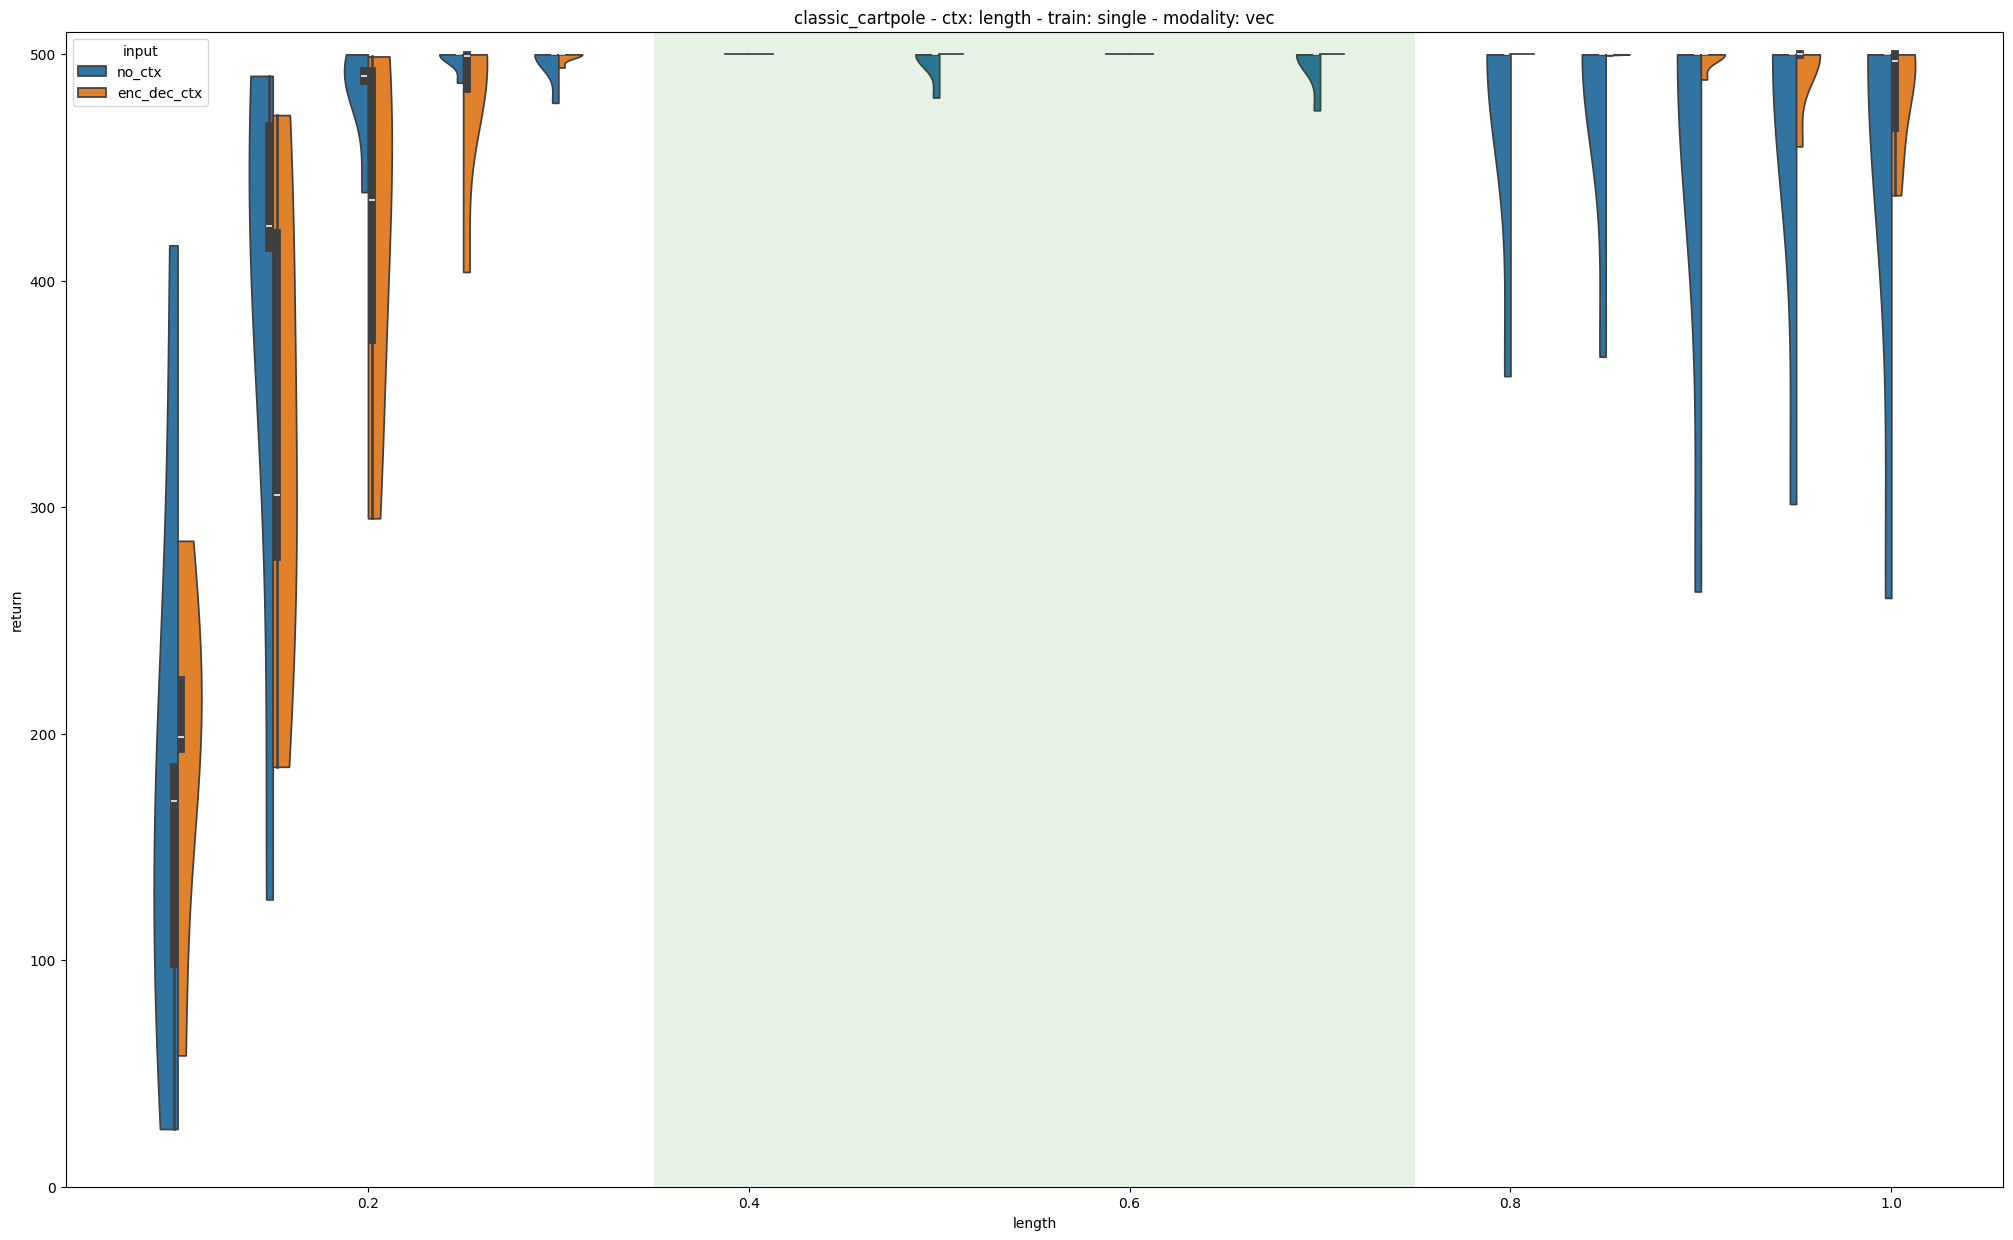

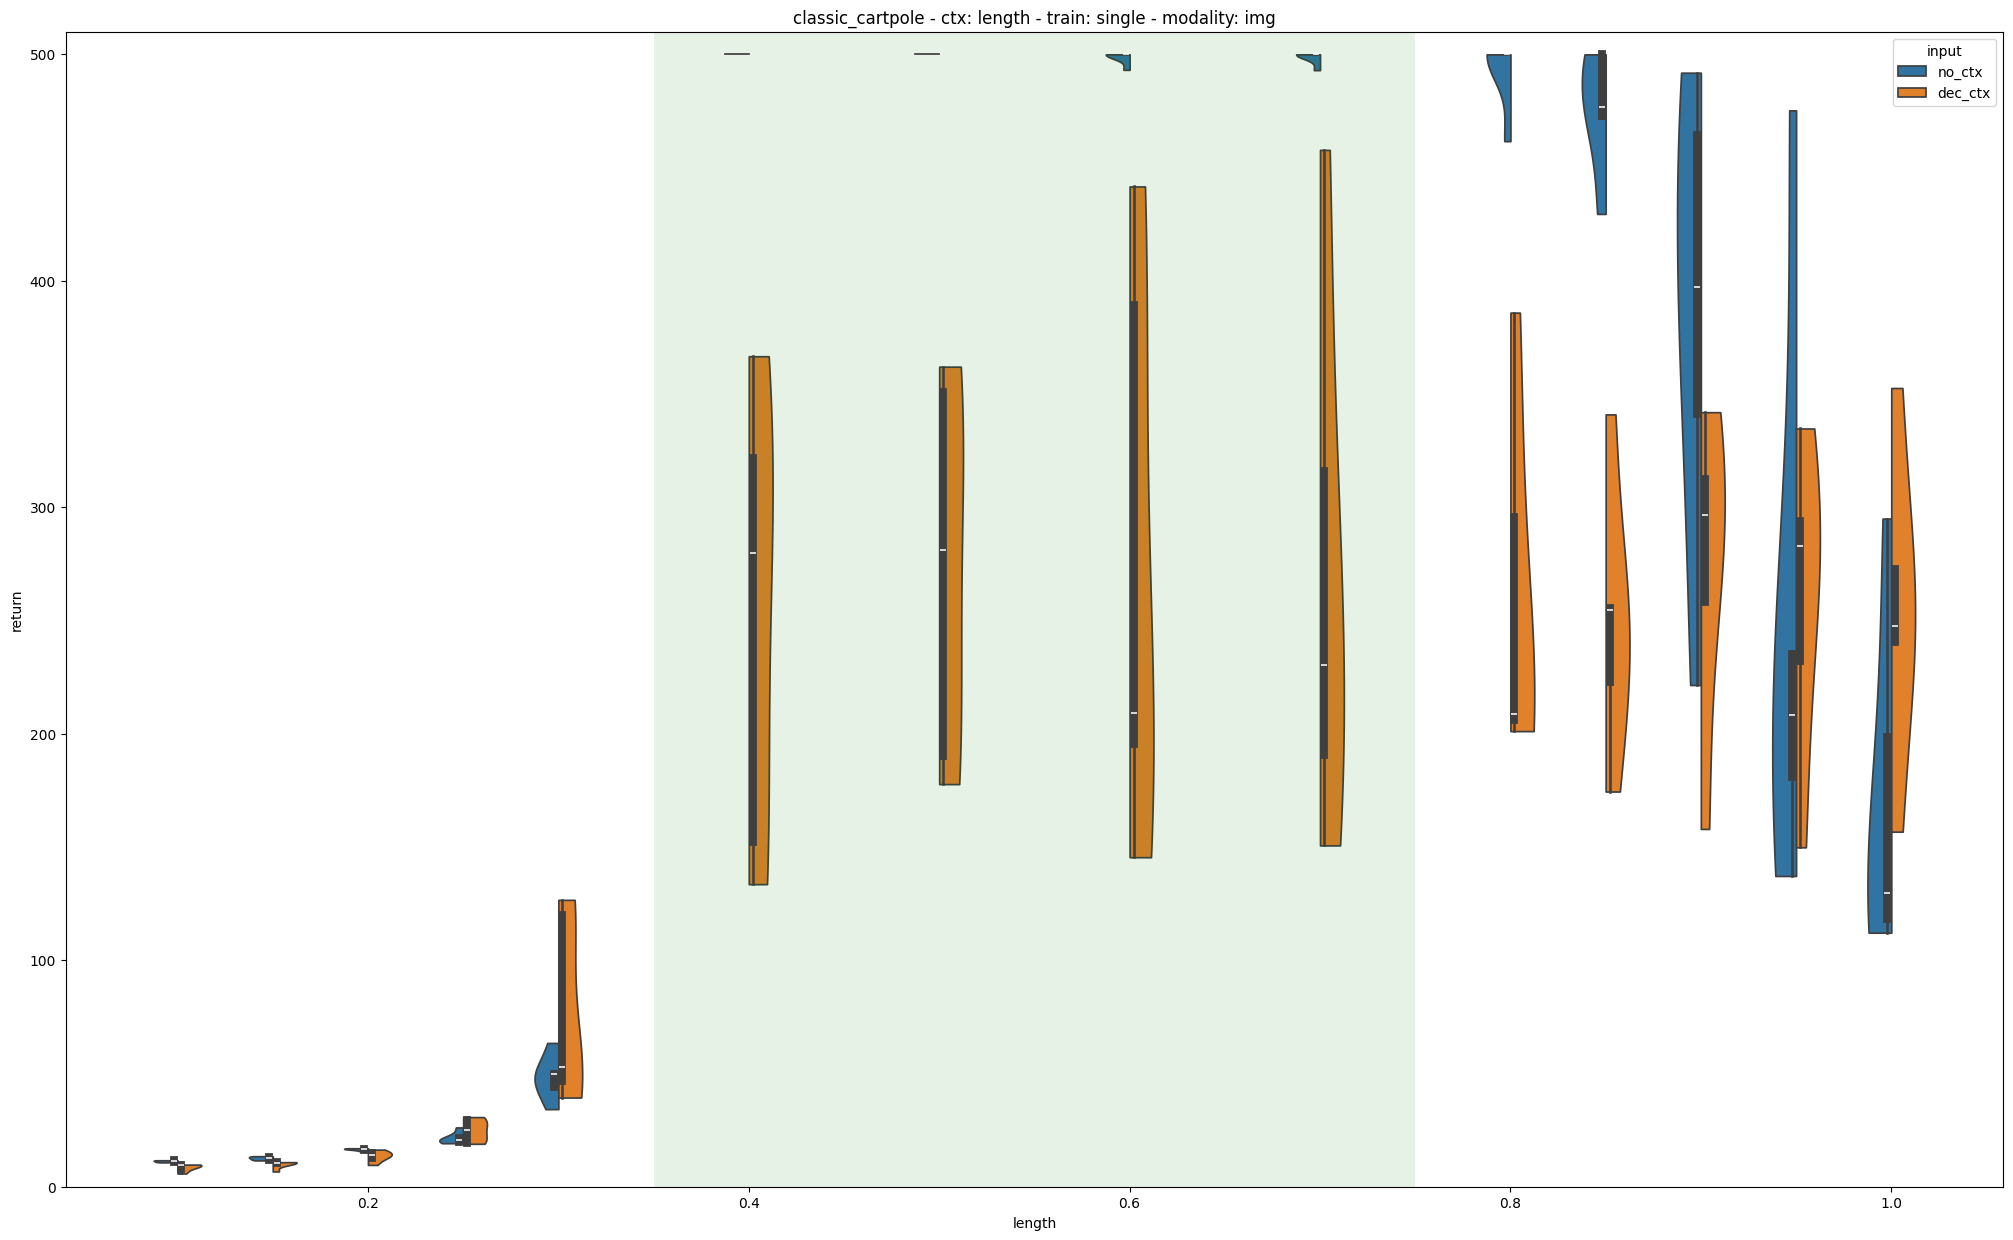

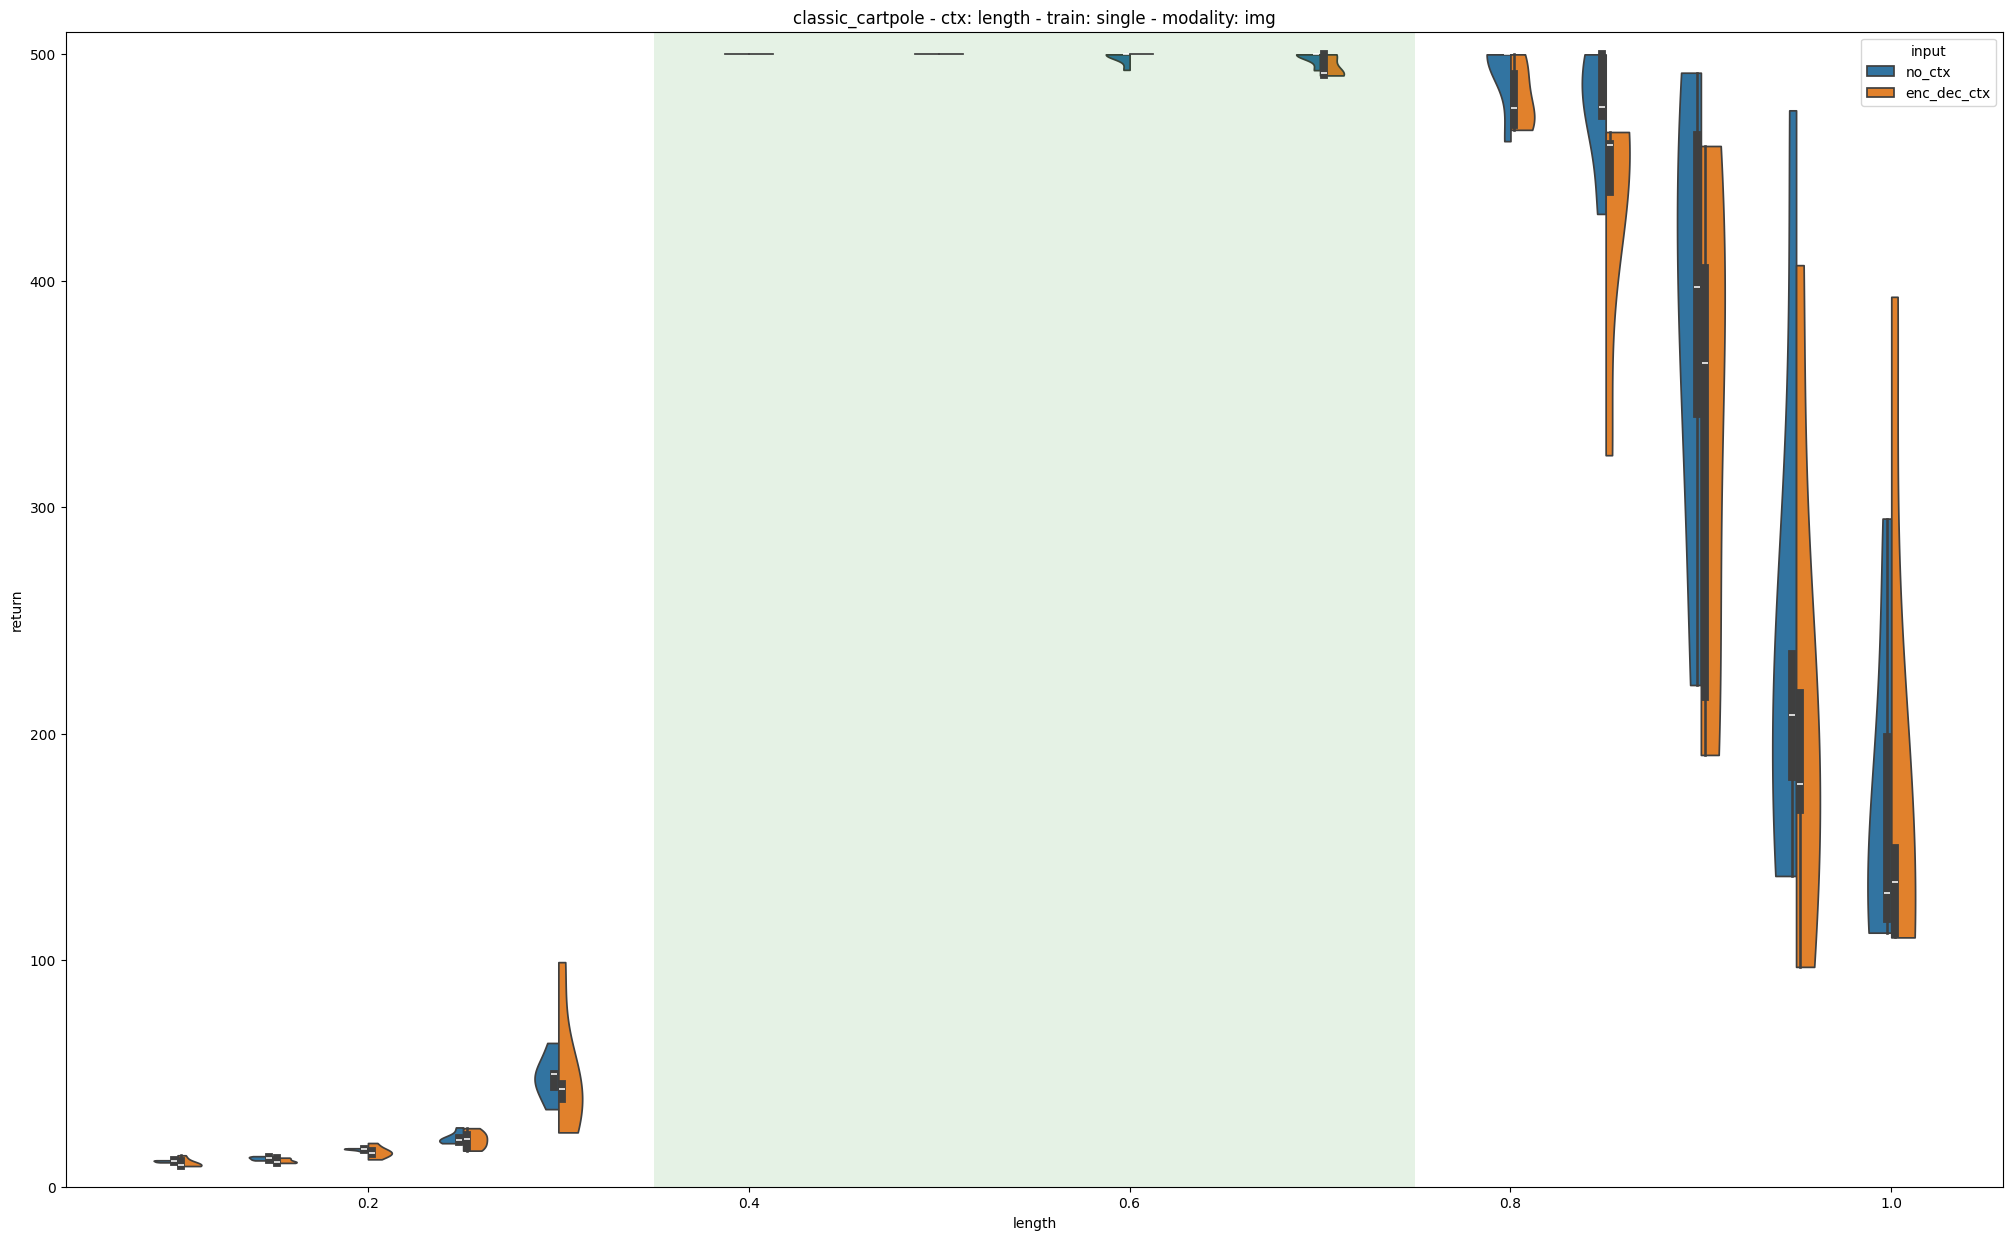

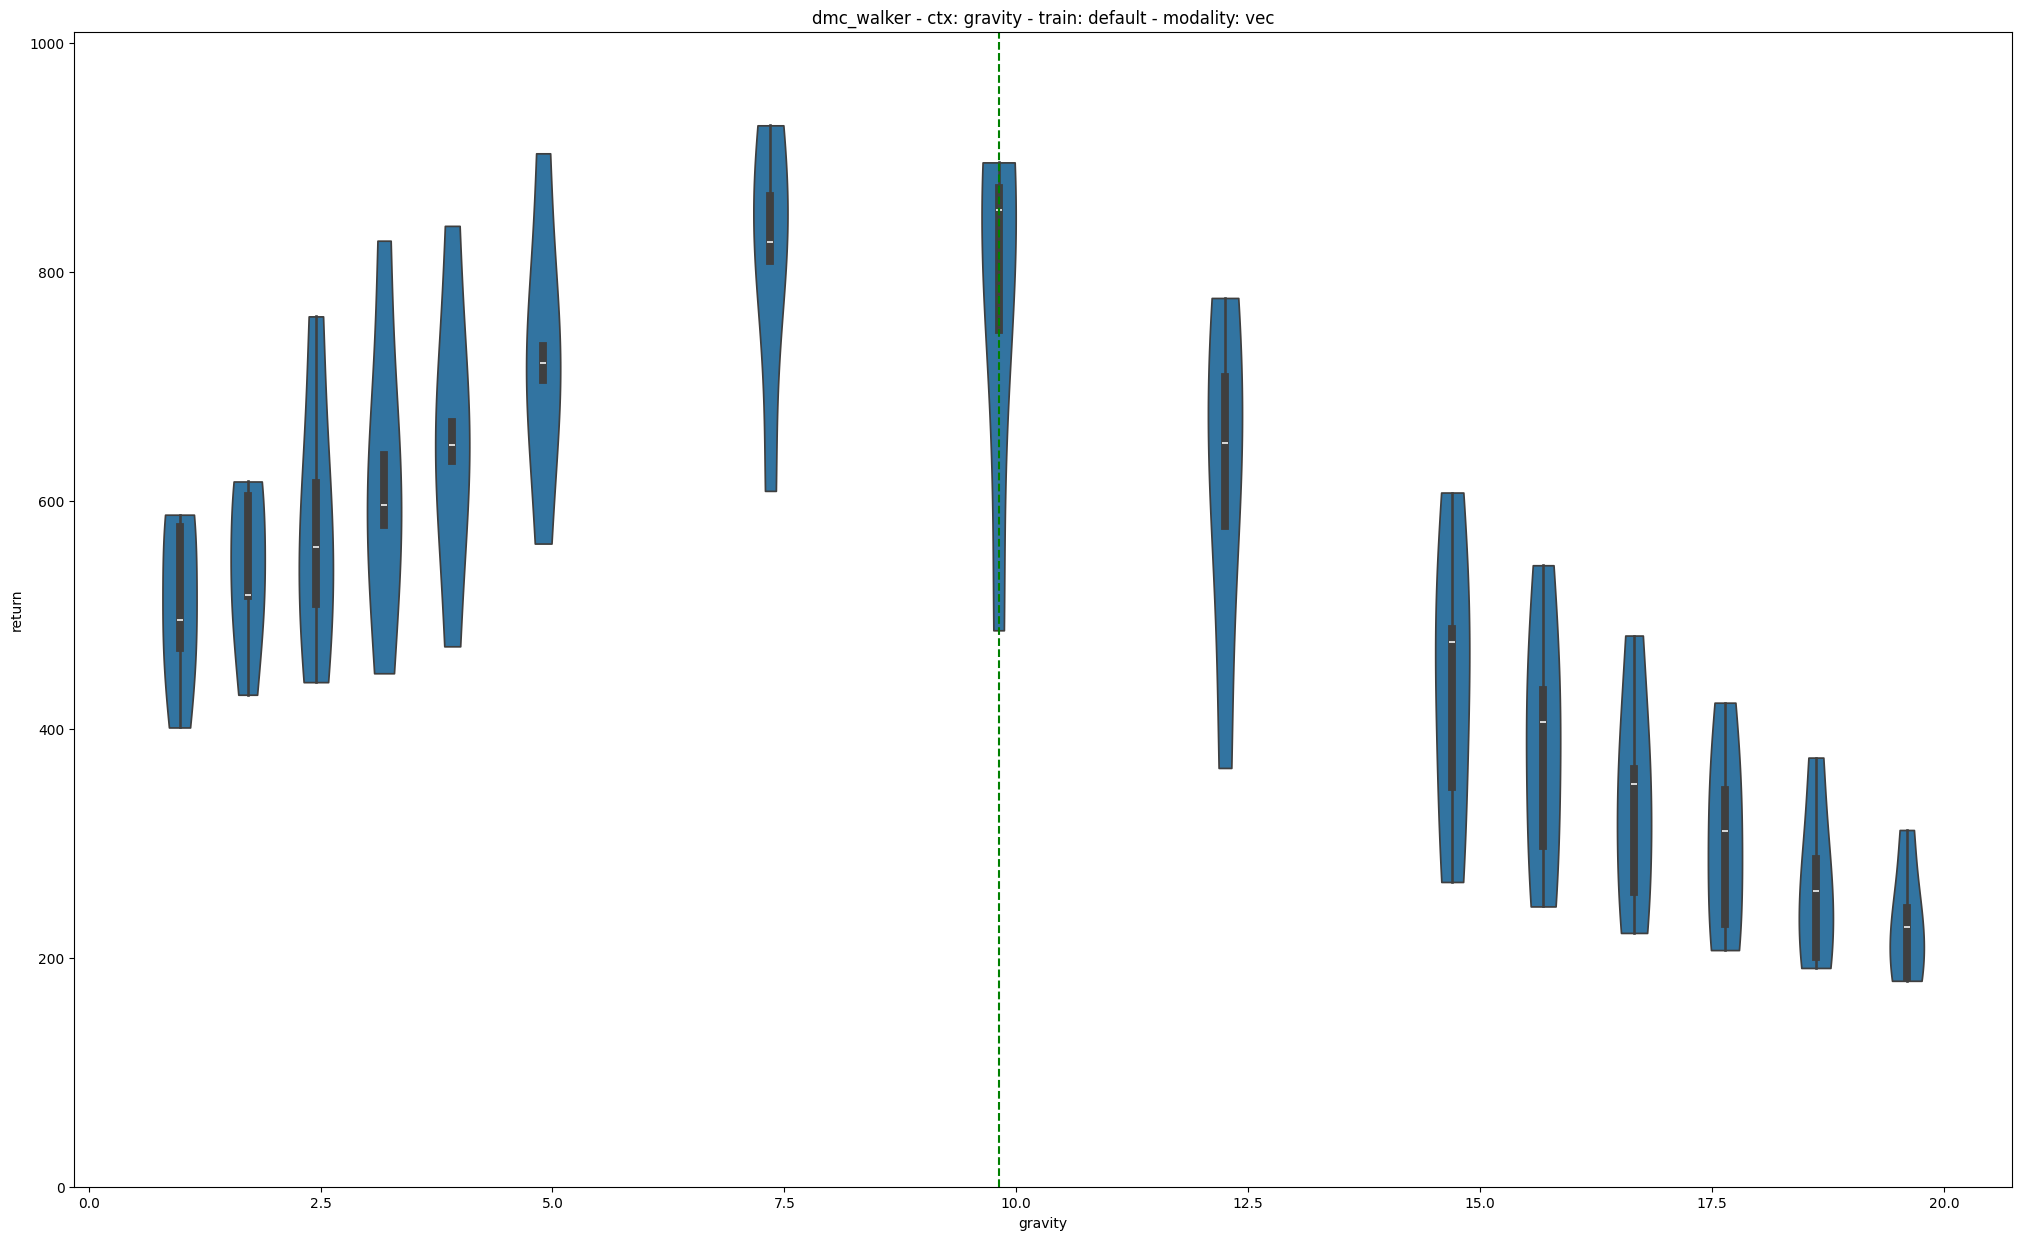

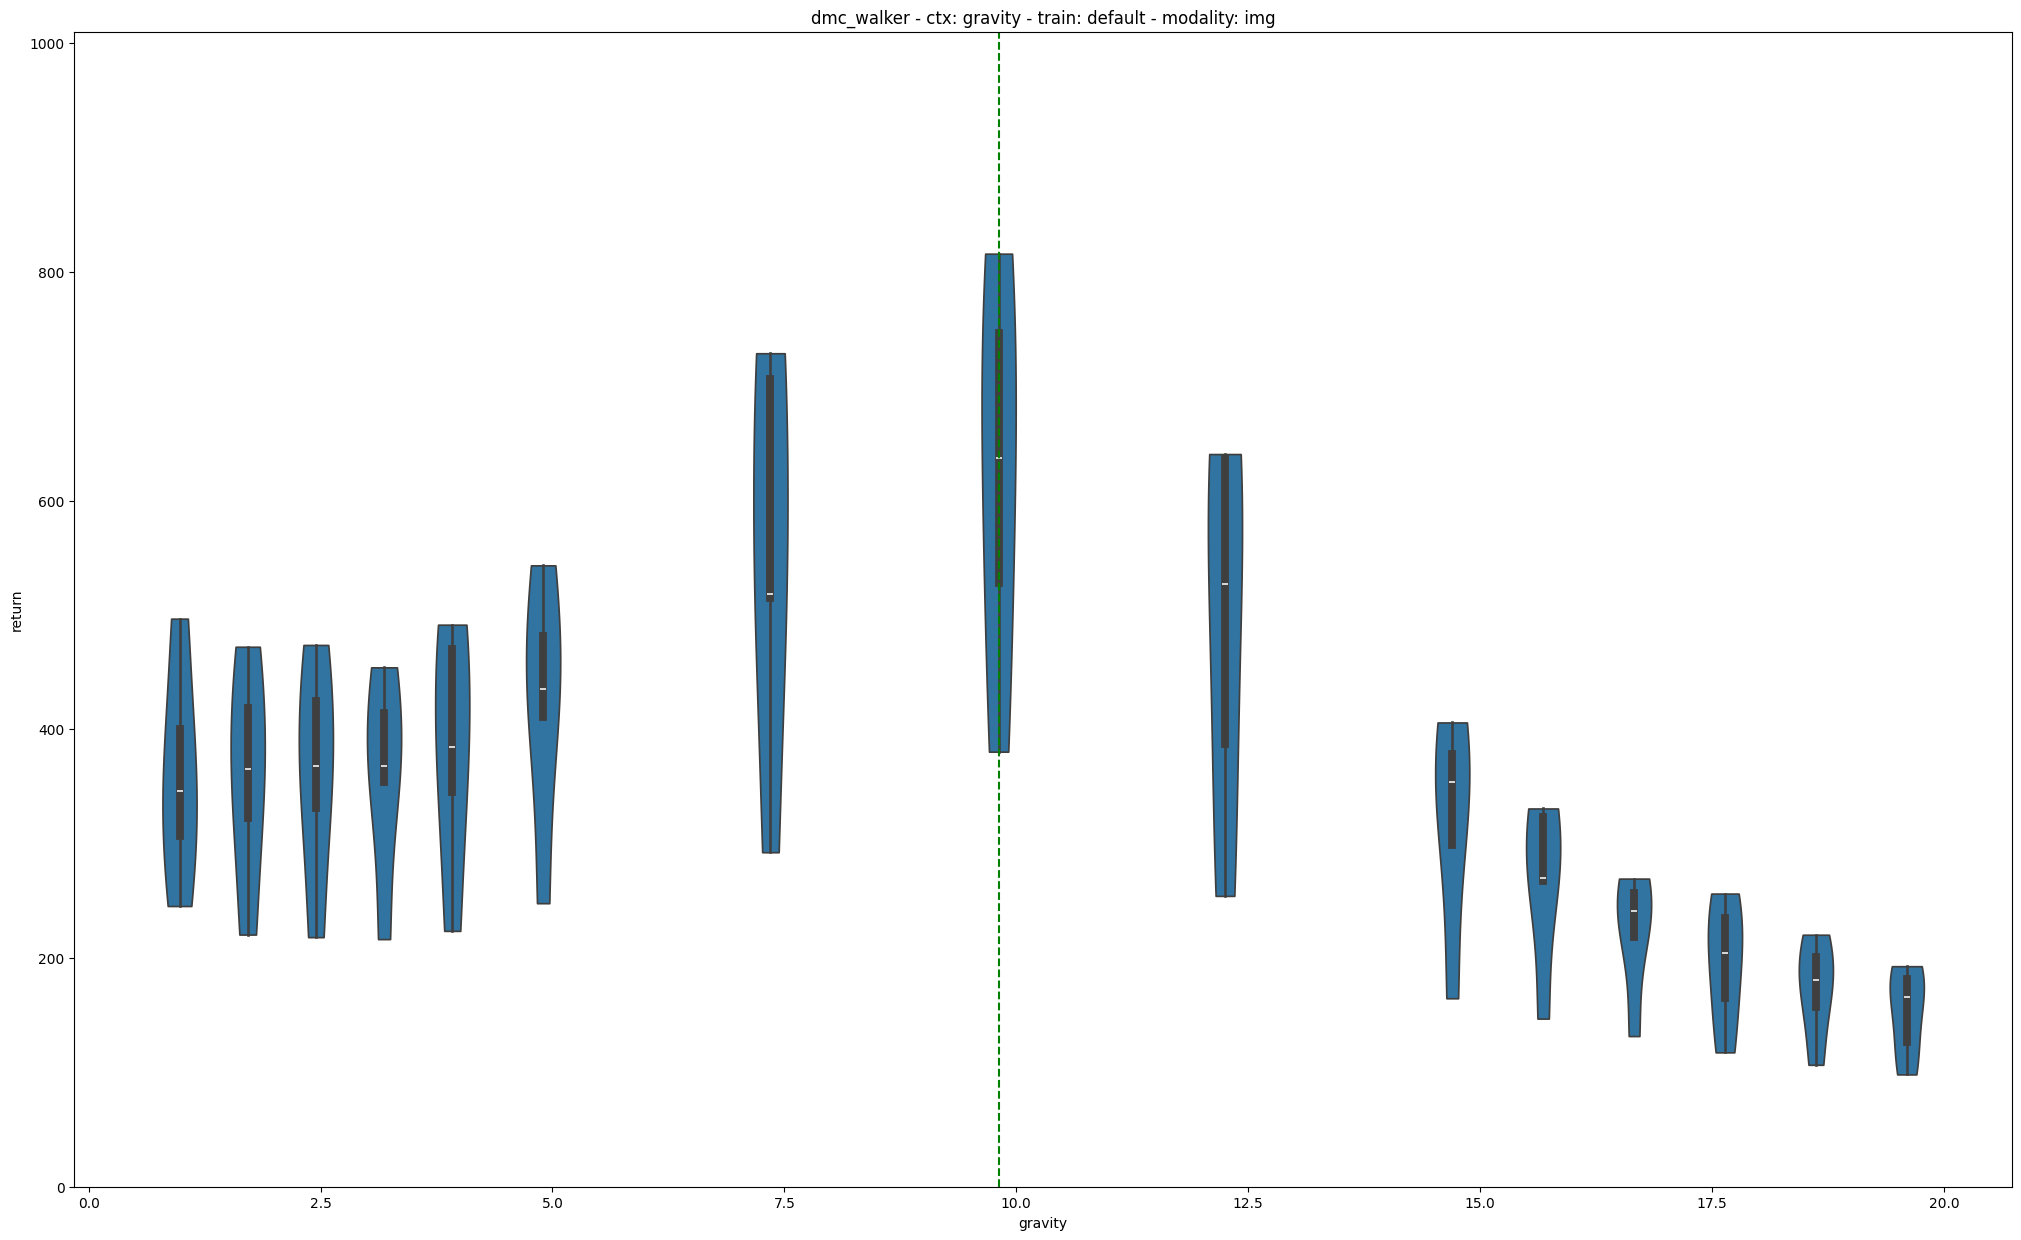

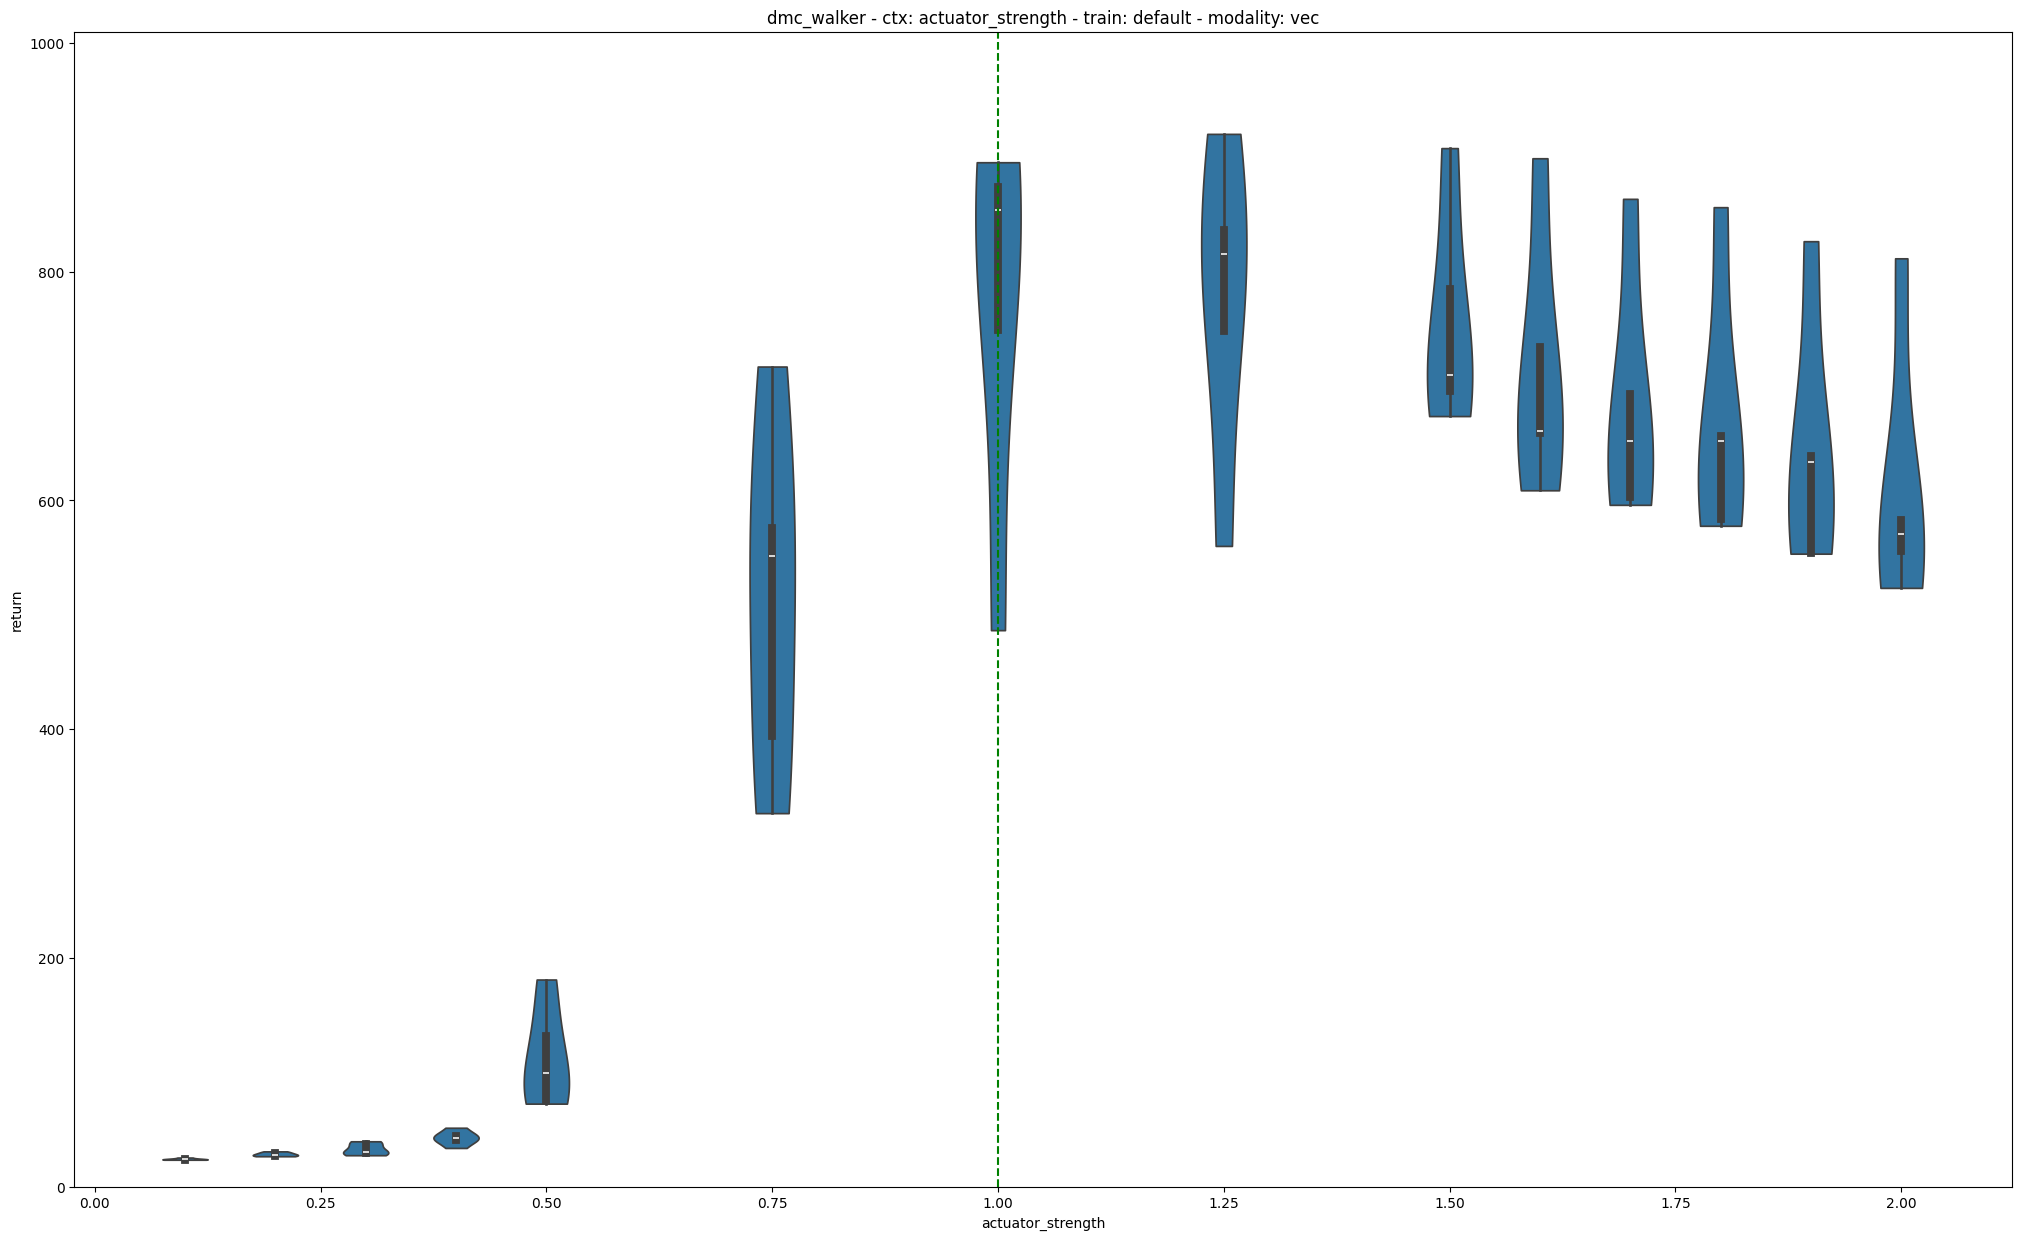

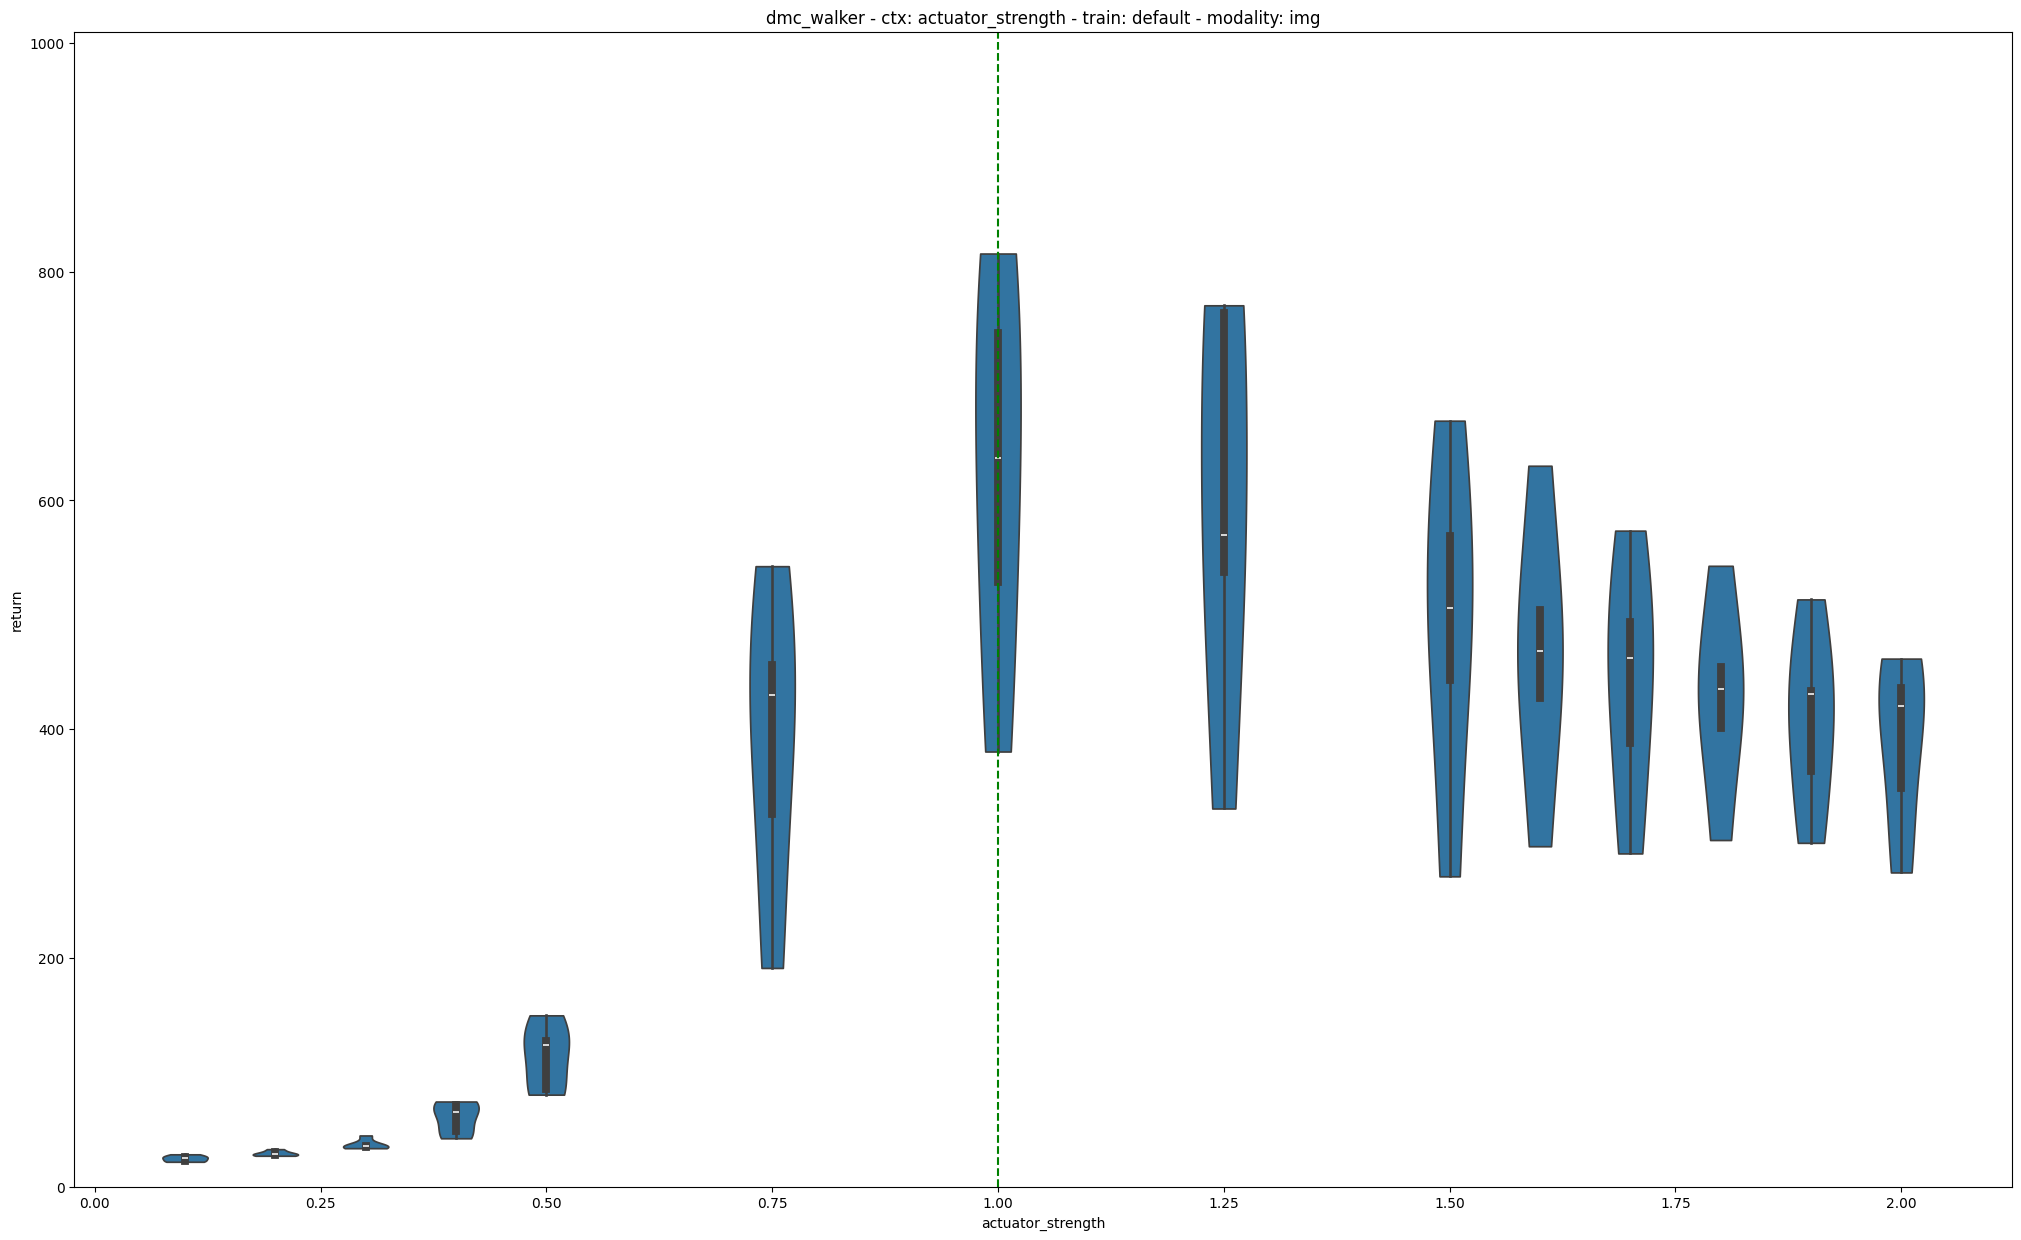

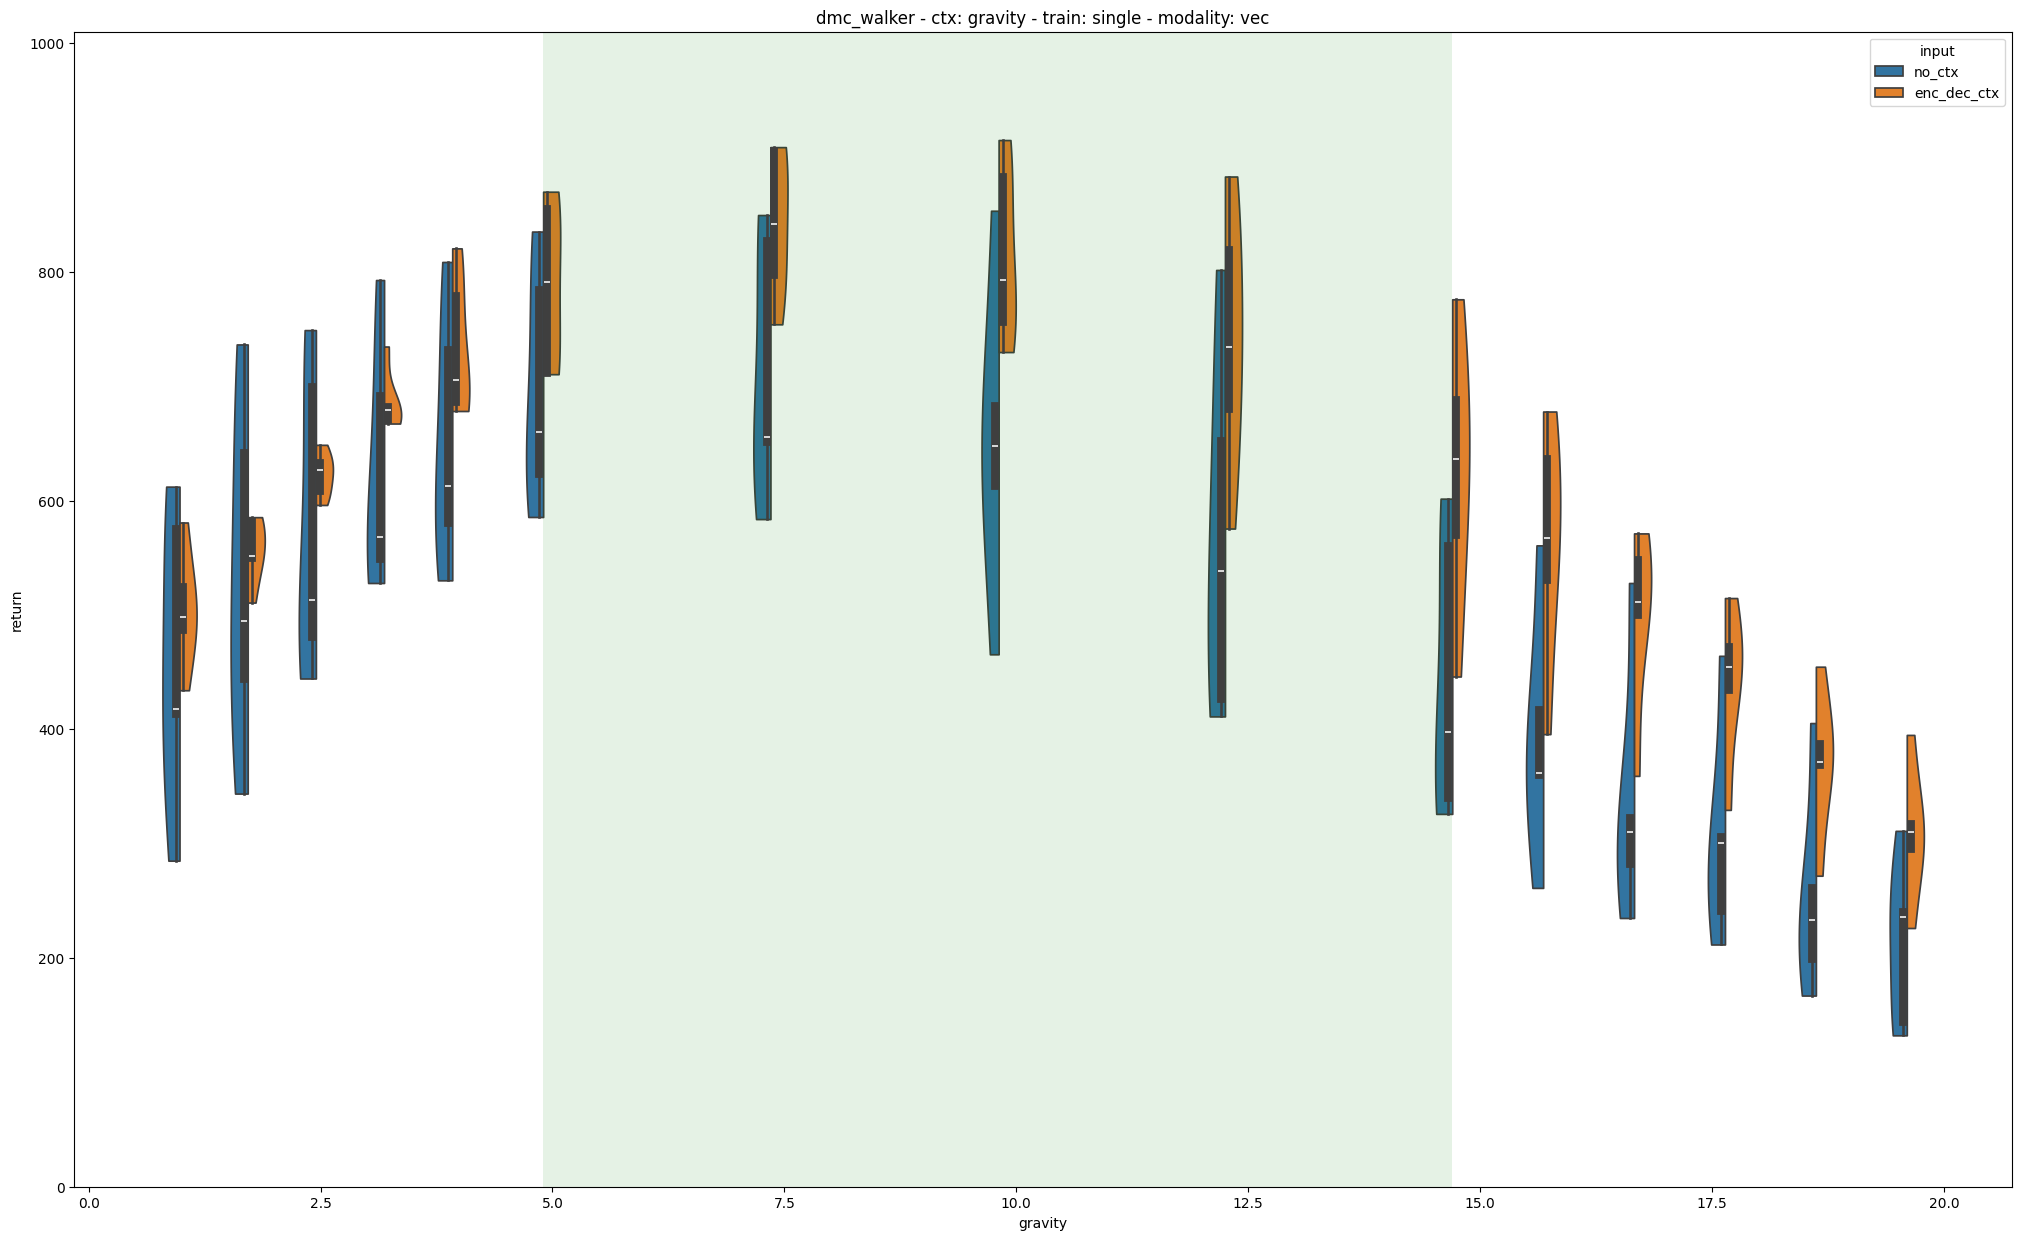

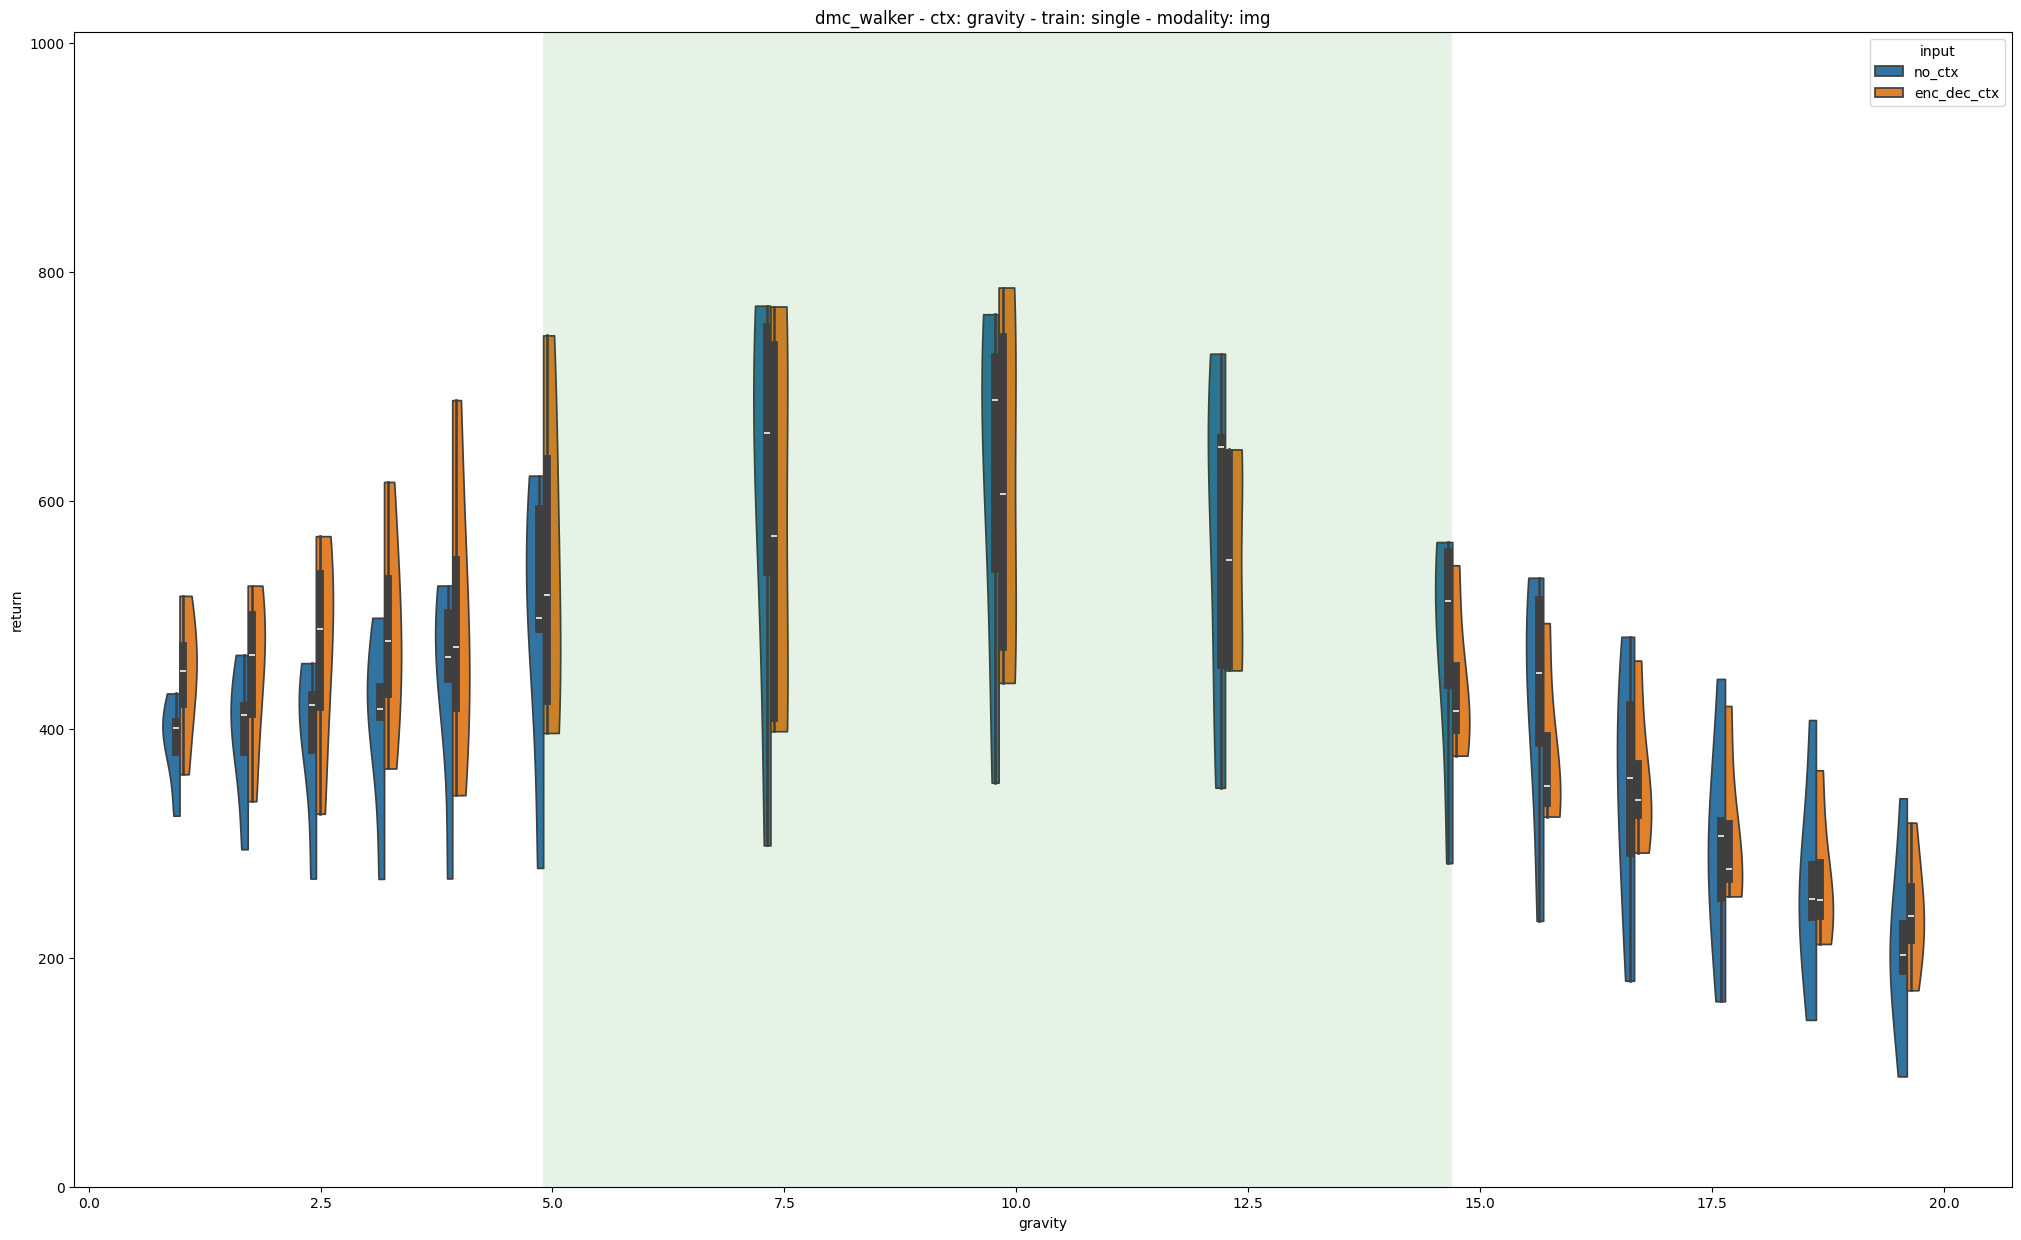

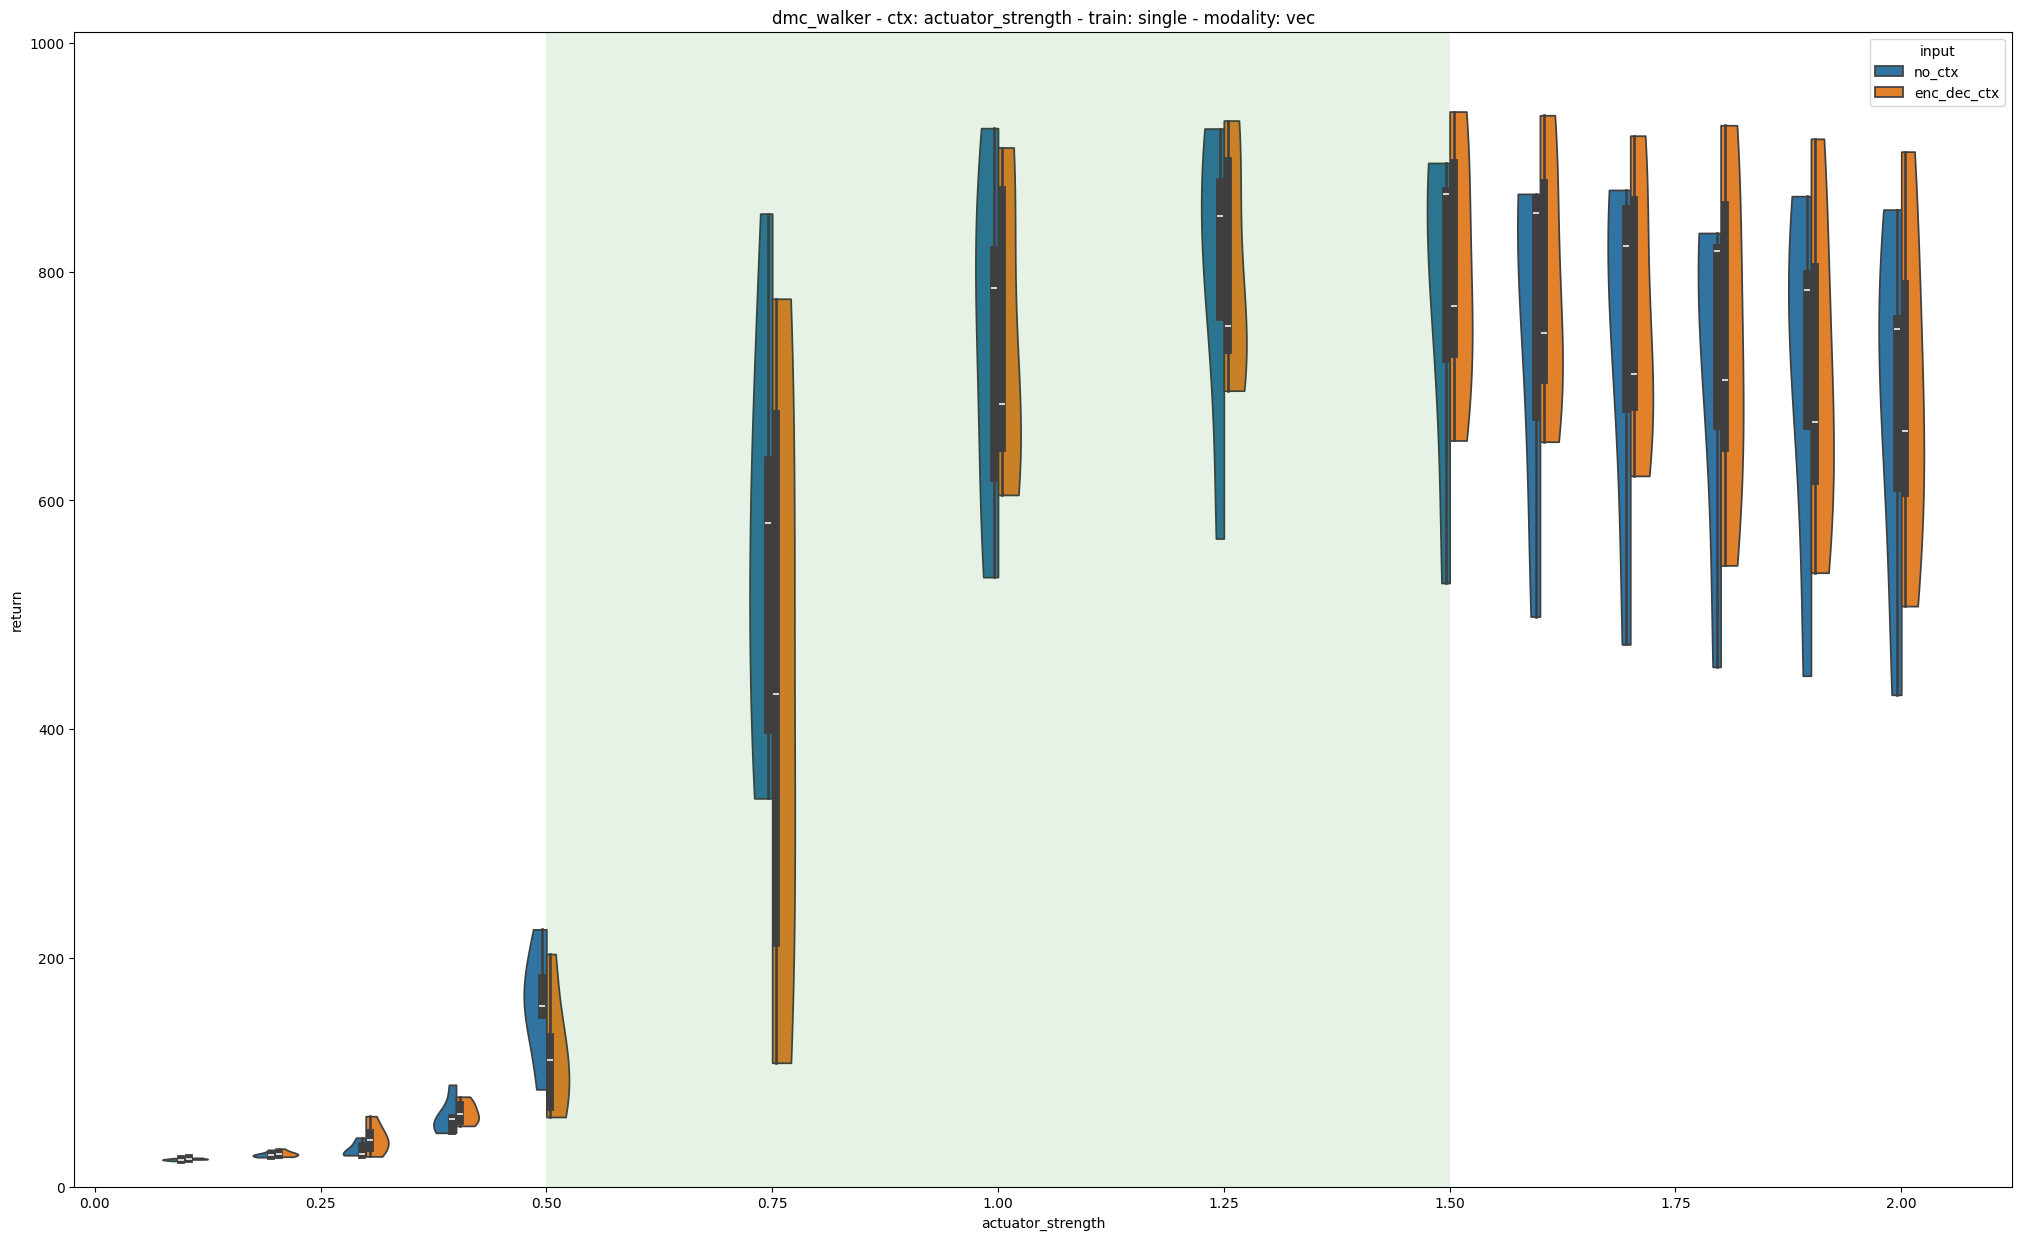

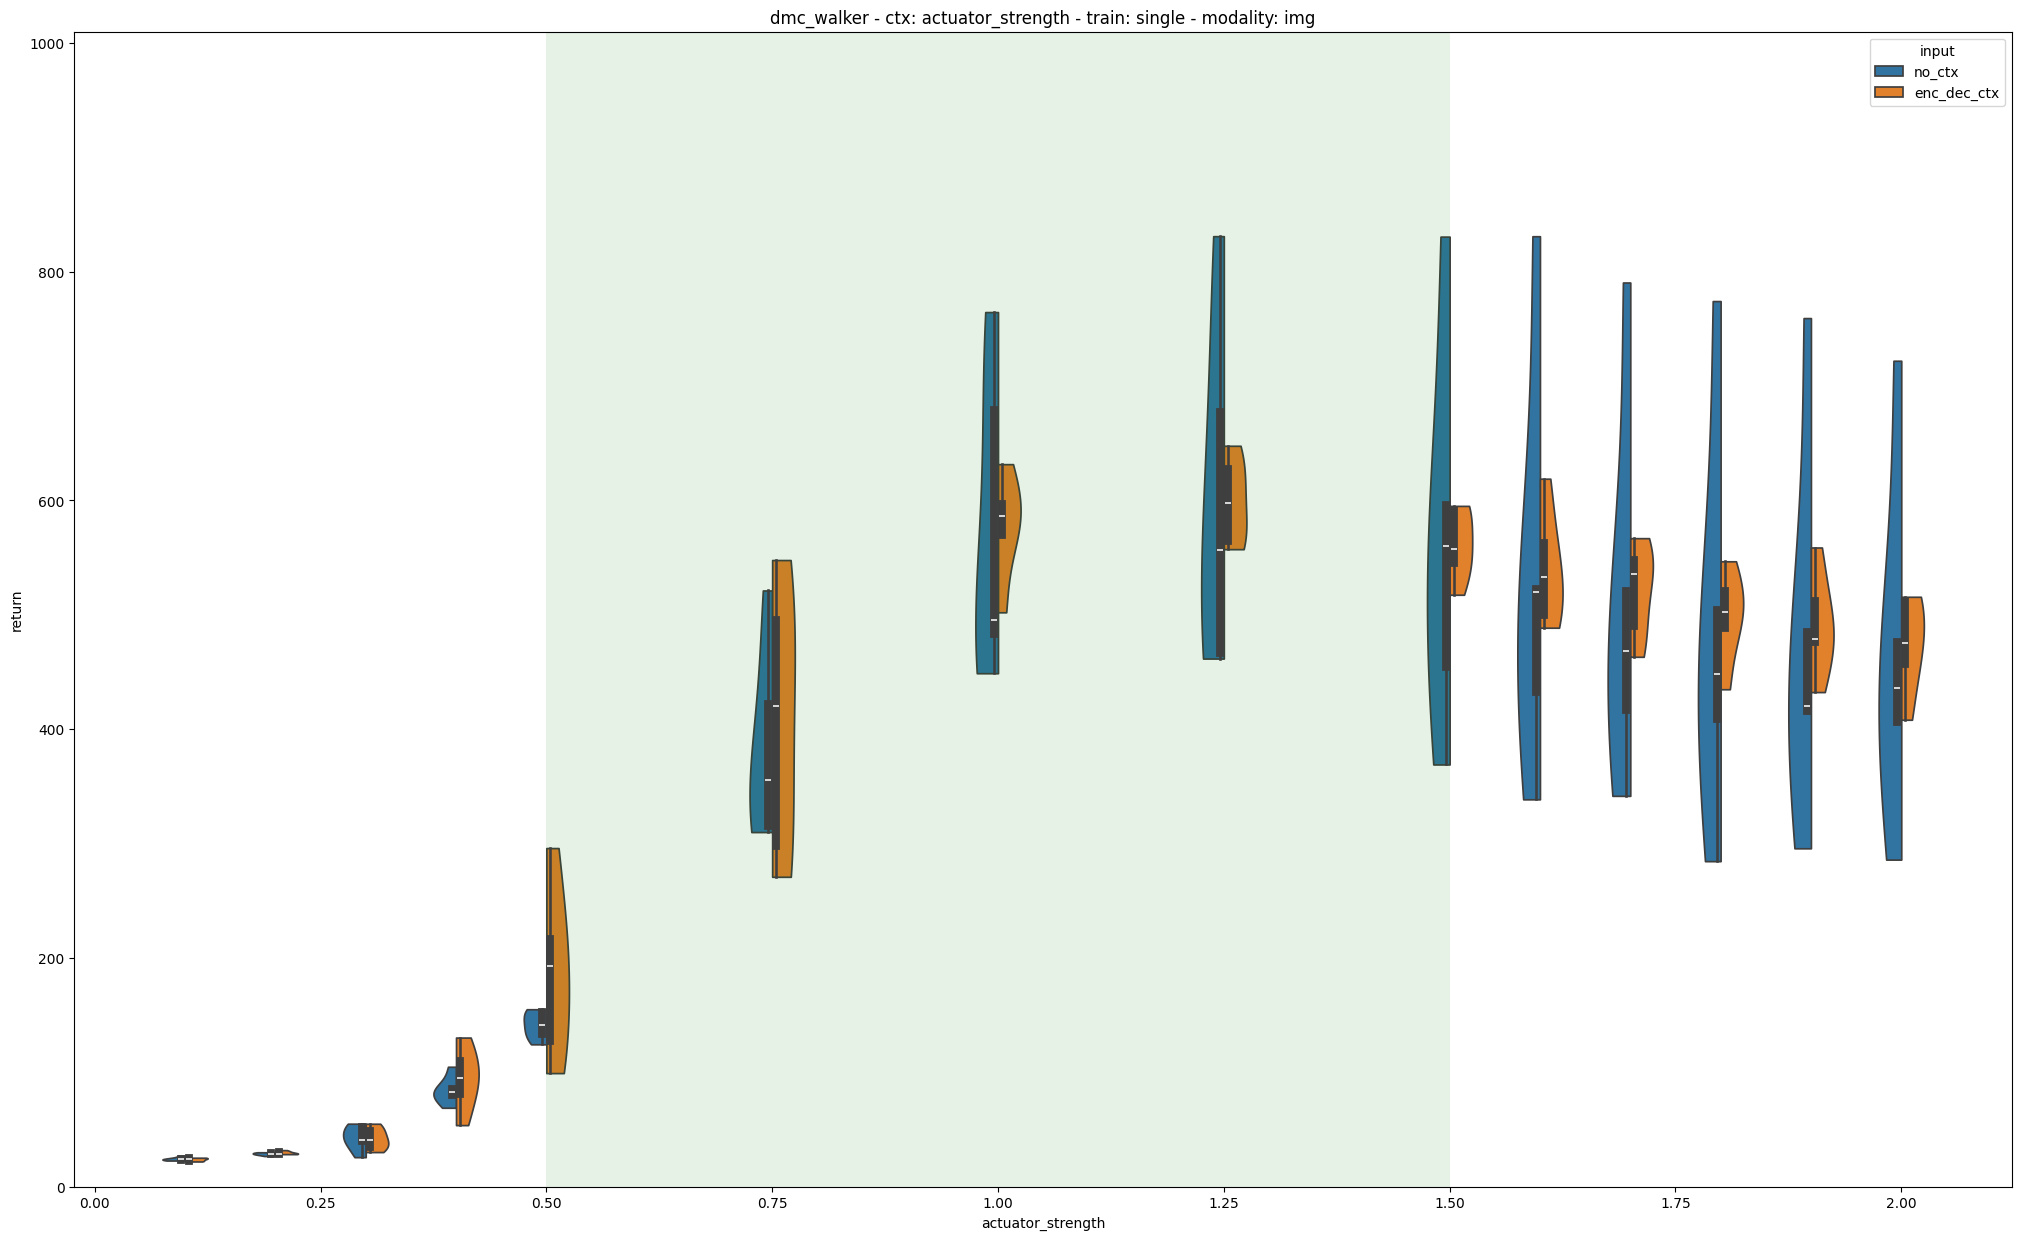

In [41]:

tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

for task in tasks:
    for train_setting in train_settings:
        for context_id in context_ids:
            for modality in modalities:
                if task == "dmc_walker":
                    decode_ctx = [False]
                else:
                    decode_ctx = [True, False]     
                for only_decode_ctx in decode_ctx:
                    plot_violin_plots(task, train_setting, context_id, modality, save_dir, logdir, only_decode_ctx, "normalized")


In [39]:
import json
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import sem
from pathlib import Path
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle


def plot2d(logdir, save_dir, task, modality, train_mode, ctx, exp_suffix):


    data = defaultdict(list)


    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]

    if train_mode == "default":
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        interpolate_range_0 = [default_0, default_0]
        interpolate_range_1 = [default_1, default_1]
    else:
        interpolate_range_0 = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_range_1 = _TASK2CONTEXTS[task][1]["train_range"]

    if ctx == "no_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_{exp_suffix}"
    elif ctx == "enc_dec_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_ctx_dec_{modality}_ctx_{exp_suffix}"
    elif ctx == "enc_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_ctx_dec_{modality}_{exp_suffix}"
    else:
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_ctx_{exp_suffix}"
    modality = "vec" if modality == "obs" else "img"
    experiment = exp_path.name
    for seed_path in exp_path.iterdir():
        seed = int(seed_path.name)
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        for line in lines:
            
            ctx_0_value = line['ctx']["context"][ctx_0]
            ctx_1_value = line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            data[(ctx_0_value, ctx_1_value)].append(ret)


    x = []
    y = []
    c = []
    for ctx_0_value, ctx_1_value in data:
        x.append(ctx_0_value)
        y.append(ctx_1_value)
        c.append(np.mean(data[(ctx_0_value, ctx_1_value)]))


    df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c})
    df = df.pivot(index=ctx_0, columns=ctx_1, values="return")
    # sort the rows descending
    df = df.sort_index(ascending=False)
    # darker colors for higher values, red color map
    ax = sns.heatmap(df, cmap=sns.cm.rocket_r, annot=True, fmt=".0f")

    h_index_0 = df.index.searchsorted(interpolate_range_0[0], 'left', df.index.argsort())
    h_index_1 = df.index.searchsorted(interpolate_range_0[1], 'right', df.index.argsort())

    v_index_0 = df.columns.searchsorted(interpolate_range_1[0], 'left')
    v_index_1 = df.columns.searchsorted(interpolate_range_1[1], 'right')
    
    ax.add_patch(Rectangle((v_index_0, h_index_0), (v_index_1 - v_index_0), (h_index_1 - h_index_0), fill=False, edgecolor='g', linestyle='--', linewidth=2))
    plt.title(f"{task} - {train_mode} - {modality} - {ctx}")
    
    plt.savefig(save_dir / f"{task}_double_{ctx_0}_{ctx_1}_{train_mode}_{modality}_{ctx}.pdf")
    # clear plt
    plt.pause(0.1)

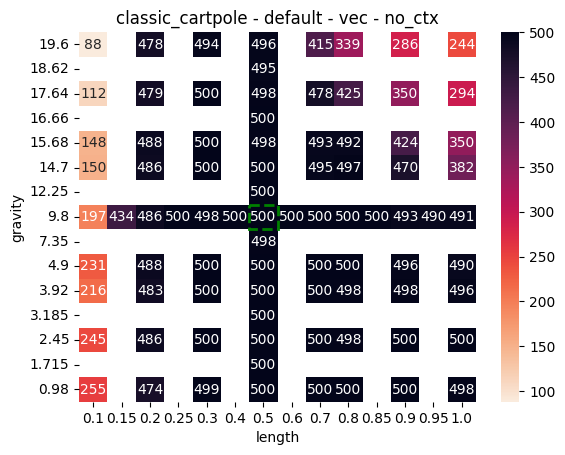

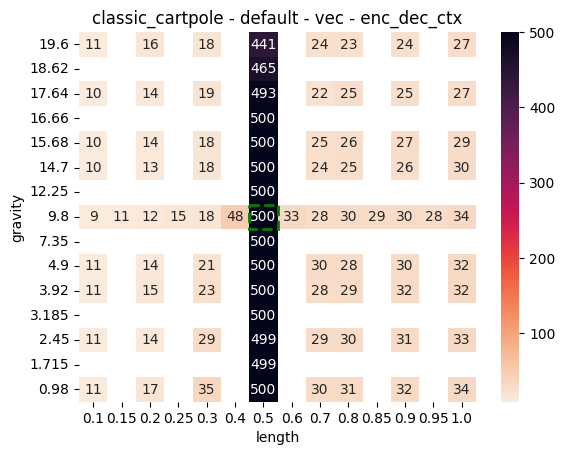

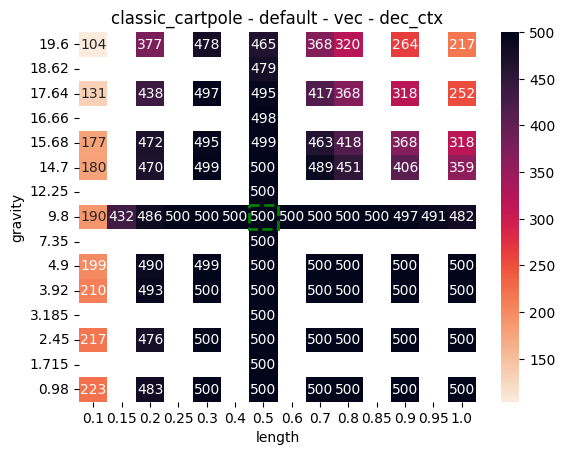

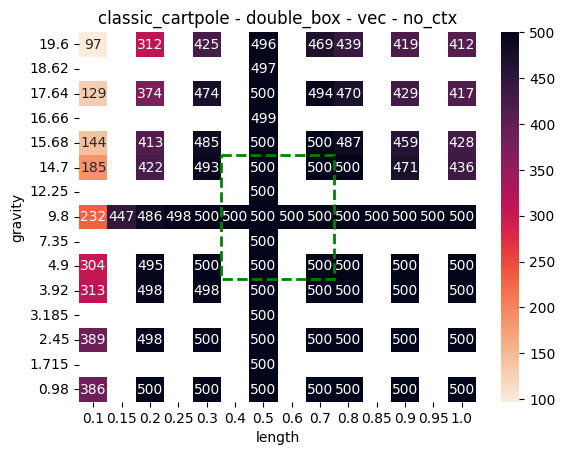

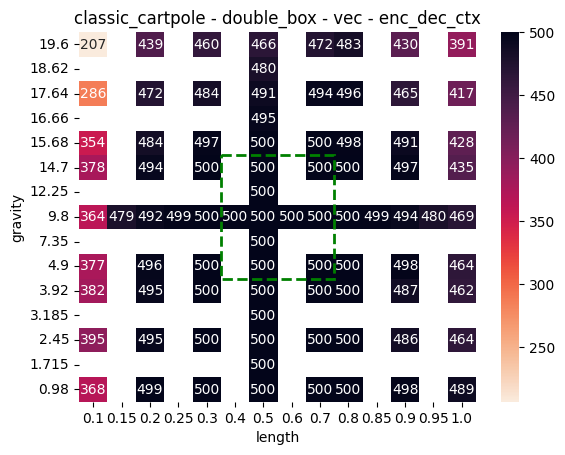

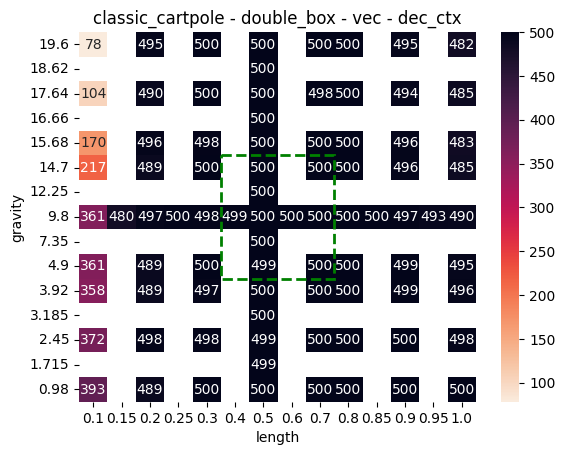

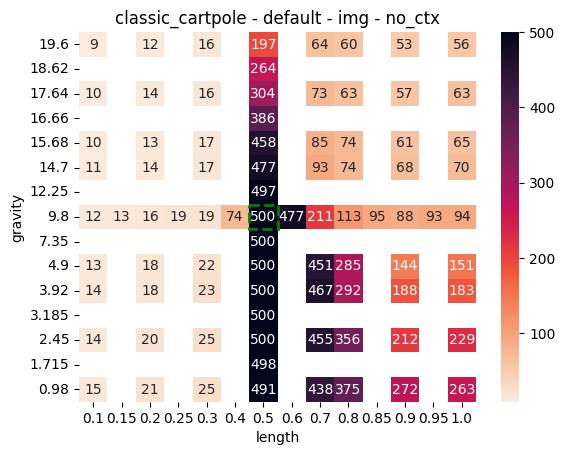

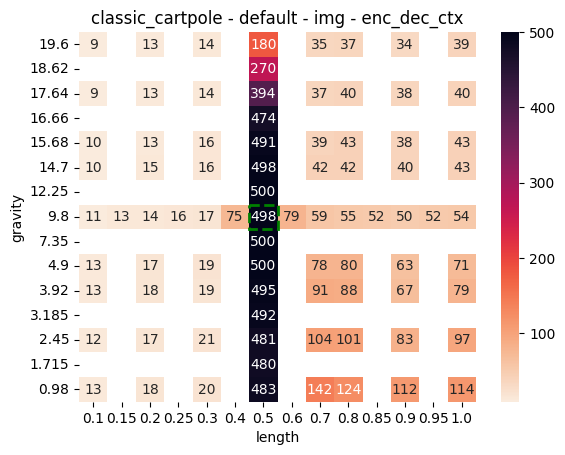

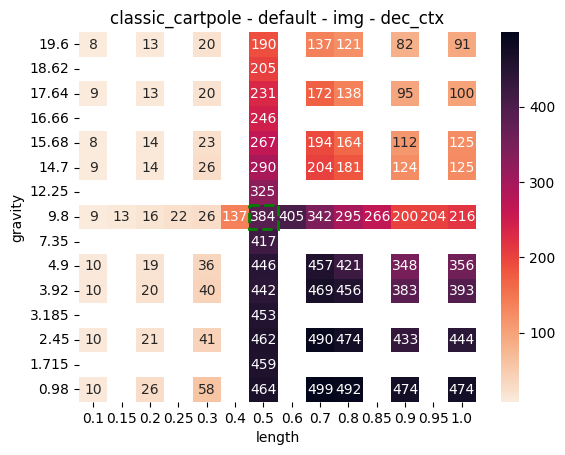

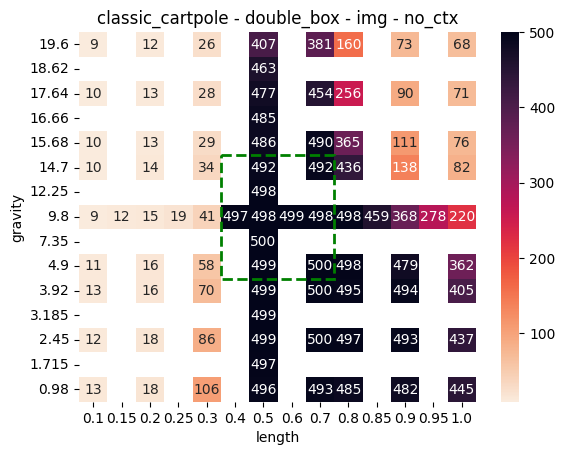

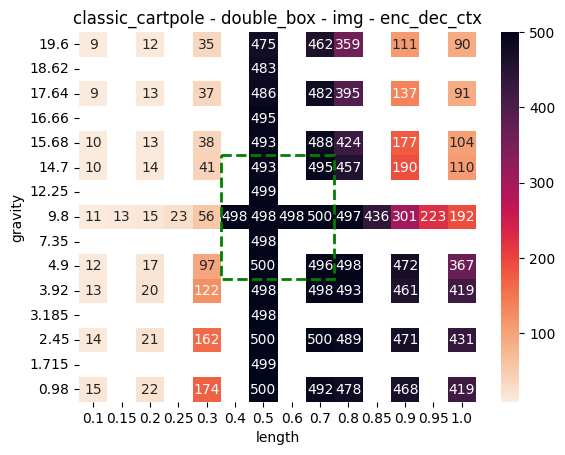

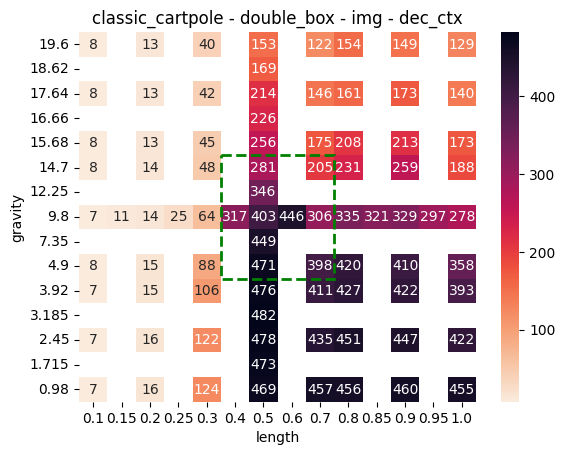

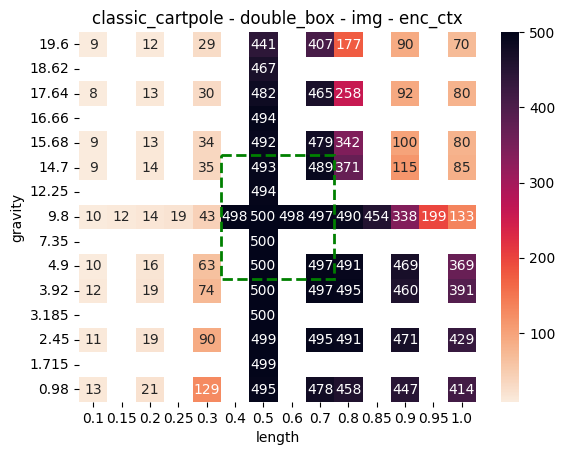

In [40]:
exp_suffix = "normalized"
tasks = ["classic_cartpole"]
modalities = ["obs", "img"]
train_modes = ["default", "double_box"]
logdir = Path("../logs") 

save_dir = Path("./plots/")
for task in tasks:
    for modality in modalities:
        for train_mode in train_modes:
            for ctx in ["no_ctx", "enc_dec_ctx", "dec_ctx"]:
                plot2d(logdir, save_dir, task, modality, train_mode, ctx, exp_suffix)
            if modality == "img" and train_mode == "double_box":
                plot2d(logdir, save_dir, task, modality, train_mode, "enc_ctx", exp_suffix)